In [1]:
config = {
    'MAX_LEN' : 200, #max length of a sequence 
    'bs' : 16, #batch size
    'substitue' : 'X', #substitute tag
    'name' : 'bert-base-uncased', #model name
    'do_lower_case' : True, #lower case
    'fold_num' : 5, #number of fold to cross validation
    'hidden_size' : 768, #input size of classifier
    'dropout' : 0.1, #dropout rate
    'decay' : 1e-5, #weight decay
    'lr' : 4e-5, #learning rate
    'mu' : 5, #parameter in computing weights
    'FULL_FINETUNING' : True, #if finetune bert or not
    'max_grad_norm' : 1.0, #grad clipping
    'epochs' : 50, #training epochs
    'period' : 10, #period of display training results
}

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import pickle as pk

#add pname at the beginning of the sentence
def add_pname(data, cve_cpe_pnames):
    def add(pname):
        if len(pname)==0:
            return [], []
        add_sent = ['Product','name','is']
        add_label = ['O','O','O']
        #only consider pname without '_'
        pname = [i for i in pname if '_' not in i]

        for i in range(len(pname)):
            spl_name = pname[i].split()
            add_sent.extend(spl_name)
            add_label.extend(['pn']*len(spl_name))

            if i!=len(pname)-1:
                add_sent.append(',')
            else:
                add_sent.append('.')
            add_label.append('O')
        return add_sent, add_label

    def agg_func(s):
        add_sent, add_label = add(cve_cpe_pnames[s.name[0]])
        new_sent = add_sent + s["token"].values.tolist()
        new_tag = add_label + s["label"].values.tolist()
        return [(w, t) for w, t in zip(new_sent, new_tag)]


    grouped = data.groupby(['sent_ind','cve_sent_ind']).apply(agg_func)
    words = [w for w in grouped]
    return words

def read_data(path):
    data = pd.read_csv(path, encoding="latin1").fillna(method="ffill")
    count_label = data.groupby('label')['sent_ind'].count()
    # sentence id
    i=0
    cve_sent_ind = 0
    sent_ind = data.loc[0]['sent_ind']
    while i<len(data):
        d = data.loc[i]
        if d['sent_ind']==sent_ind:
            data.loc[i, 'cve_sent_ind']=cve_sent_ind
            if d['token']=='.':
                cve_sent_ind=cve_sent_ind+1
            i+=1
        else:
            sent_ind = d['sent_ind']
            cve_sent_ind = 0
            
    with open('data/cpe.pkl','rb') as f:
        cve_cpe_pnames,cve_cpe_vendors = pk.load(f)
    words = add_pname(data, cve_cpe_pnames)
    sentences = [" ".join([s[0] for s in sent]) for sent in words]
    labels = [[s[1] for s in sent] for sent in words]
    substitue = config['substitue']
    tags_vals = list(set(data["label"].values)) + [substitue]
    tag2idx = {t: i for i, t in enumerate(tags_vals)}
    return words, sentences, labels, tags_vals, tag2idx


In [3]:
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler



def vectorization(config, sentences, labels, tags_vals, tag2idx):
    #use bert tokenization and substitute label
    #vectorize and pad dataset
    tokenizer = BertTokenizer.from_pretrained(config['name'], do_lower_case=config['do_lower_case'])

    mytexts = []
    mylabels = []
    for sent, tags in zip(sentences,labels):
        BERT_texts = []
        BERT_labels = np.array([])
        for word, tag in zip(sent.split(),tags):
            sub_words = tokenizer.tokenize(word)
            n_underscore = sub_words.count('_') 
            for i in range(n_underscore):
                sub_words.remove('_')
            tags = np.array([tag for x in sub_words])
            tags[1:] = config['substitue']
            BERT_texts += sub_words
            BERT_labels = np.append(BERT_labels,tags)
        mytexts.append(BERT_texts)
        mylabels.append(BERT_labels)

    l = 0
    for w in mytexts:
        if len(w)>l:
            l = len(w)
    print('The longest sentence has {} tokens.'.format(l))

    MAX_LEN = config['MAX_LEN']
    #padding data
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in mytexts],
                              maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in mylabels],
                         maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                         dtype="long", truncating="post")
    attention_masks = np.array([[float(i>0) for i in ii] for ii in input_ids])
    data_fold = (input_ids, tags, attention_masks)
    return data_fold

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [4]:
def myDataLoader(data_fold, train_index, test_index):
    bs = config['bs']
    input_ids, tags, attention_masks = data_fold
    
    tr_inputs, val_inputs = input_ids[train_index], input_ids[test_index]
    tr_tags, val_tags = tags[train_index], tags[test_index]
    tr_masks, val_masks = attention_masks[train_index], attention_masks[test_index]
    
    tr_inputs = torch.tensor(tr_inputs)
    val_inputs = torch.tensor(val_inputs)
    tr_tags = torch.tensor(tr_tags)
    val_tags = torch.tensor(val_tags)
    tr_masks = torch.tensor(tr_masks)
    val_masks = torch.tensor(val_masks)
    
    train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs, drop_last=False)

    valid_data = TensorDataset(val_inputs, val_masks, val_tags)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs, drop_last=False)
    dataloader = (train_dataloader, valid_dataloader)
    
    count = np.unique(tr_tags, return_counts=True)[1]
    return dataloader, count

In [5]:
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

def BuildModel(config, weight=None):
    # change the forward method: do not consider 'X' when computing loss
    def new_forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None, weight=weight):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        if labels is not None:
            if weight is not None:
                weight = weight.to(torch.float).to(config['device'])
            loss_fct = nn.CrossEntropyLoss(weight=weight, ignore_index=self.num_labels-1)
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = (attention_mask.view(-1) == 1) #* (labels.view(-1) != self.num_labels-1)
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        else:
            return logits
    BertForTokenClassification.forward = new_forward
    model = BertForTokenClassification.from_pretrained(config['name'], num_labels=len(tag2idx))
    model.to(config['device'])
    
    return model

In [6]:
from seqeval.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix ,f1_score, accuracy_score, classification_report
def test(config, model, dataloader, validation = False):
    #dataloader is only validation data or test data
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in dataloader:
        batch = tuple(t.to(config['device']) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        
        active = ((b_input_mask.view(-1) == 1) * (b_labels.view(-1) != len(tag2idx)-1))
        active_logits = logits.view(-1, len(tag2idx))[active].cpu().numpy()
        active_labels = b_labels.view(-1)[active].cpu().numpy()
        pred_labels = np.argmax(active_logits, axis=1)
#         label_ids = b_labels.to('cpu').numpy()
#         logits = logits.detach().cpu().numpy()
        predictions.append(pred_labels)
        true_labels.append(active_labels)
        
#         tmp_eval_accuracy = np.sum(pred_labels == active_labels) / len(active_labels)
        
        eval_loss += tmp_eval_loss.mean().item()
#         eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
#     eval_accuracy = eval_accuracy/nb_eval_steps
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    
    eval_accuracy = accuracy_score(true_labels, predictions, normalize=True, sample_weight=None)
    f1 = f1_score(true_labels, predictions, average='macro')
    if validation==True:
        return eval_loss, eval_accuracy, f1
    else:
        print("Test loss: {}".format(eval_loss))
        print("Test Accuracy: {}".format(eval_accuracy))
        print("micro F1-Score: {}".format(f1_score(true_labels, predictions, average='micro',)))
        print("macro F1-Score: {}".format(f1))
        print("weighted F1-Score: {}".format(f1_score(true_labels, predictions, average='weighted')))
        
        pred_tags = [tags_vals[p] for p in predictions]
        valid_tags = [tags_vals[l] for l in true_labels]
        counts = [valid_tags.count(tag) for tag in tags_vals]
        cfs_mat = confusion_matrix(valid_tags, pred_tags,tags_vals)
        cfs_with_index = pd.DataFrame(cfs_mat, index = tags_vals,
                      columns = tags_vals)
        cfs_mat_norm = cfs_mat/cfs_mat.sum(axis=1, keepdims = True)
        cfs_with_index_norm = pd.DataFrame(cfs_mat_norm, index = tags_vals,
                      columns = tags_vals)
        print('')
        print('test counts:')
        print(pd.DataFrame(tags_vals,counts))
        print('')
        print(classification_report(valid_tags, pred_tags))
        print('')
        print('Confusion matrix:')
        print(cfs_with_index)
        sn.heatmap(cfs_with_index_norm)
        print('')
        return predictions, true_labels, eval_loss, eval_accuracy, f1

In [7]:
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sn
from copy import deepcopy

def train(config, model, dataloader, if_plot=True, fold_id=None):
    #the dataloader is the combination of training data and validation data
    epochs = config['epochs']
    max_grad_norm = config['max_grad_norm']
    period = config['period']
    FULL_FINETUNING = config['FULL_FINETUNING']
    
    if FULL_FINETUNING:
        
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': config['decay']},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters()) 
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
    
    optimizer = Adam(optimizer_grouped_parameters, lr=config['lr'])
    
    tr_loss_list = []
    eval_loss_list = []
    eval_acc_list = []
    f1_list = []
    max_acc = 0
    max_f1 = 0
    
    train_dataloader, valid_dataloader = dataloader
    eval_loss, eval_accuracy, f1 = test(config, model, dataloader=valid_dataloader, validation=True)
    # print train loss per epoch
    print('Epoch: {}'.format(0))
    # VALIDATION on validation set
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy))
    print("F1-Score: {}".format(f1))
    print('')
    
    for epoch in range(1, epochs+1):
        # TRAIN loop
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(train_dataloader):
            # add batch to gpu
            batch = tuple(t.to(config['device']) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # forward pass
            loss = model(b_input_ids, token_type_ids=None,
                         attention_mask=b_input_mask, labels=b_labels)
            # backward pass
            loss.backward()
            # track train loss
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # update parameters
            optimizer.step()
            model.zero_grad()
        tr_loss = tr_loss/nb_tr_steps
        eval_loss, eval_accuracy, f1 = test(config, model, valid_dataloader, validation = True)
        
        if f1>max_f1:
            max_acc = eval_accuracy
            max_f1 = f1
            best_model = deepcopy(model)
            
        tr_loss_list.append(tr_loss)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_accuracy)
        f1_list.append(f1)
        
        if epoch % period == 0:
            # print train loss per epoch
            print('Epoch: {}'.format(epoch))
            print("Train loss: {}".format(tr_loss))
            # VALIDATION on validation set
            print("Validation loss: {}".format(eval_loss))
            print("Validation Accuracy: {}".format(eval_accuracy))
            print("F1-Score: {}".format(f1))
            print('')
            
    
    print('The best result: ')
    print('Validation Accuracy: {}, F1-Score: {}'.format(max_acc, max_f1))
    
    if if_plot:
#     pk.dump((tr_loss_list, eval_loss_list, eval_acc_list, f1_list), open("results/train_result.pkl",'wb'))
    
        ax1=plt.subplot(1, 3, 1)
        ax2=plt.subplot(1, 3, 2)
        ax3=plt.subplot(1, 3, 3)

        ax1.plot(tr_loss_list)
        ax1.plot(eval_loss_list)

        ax2.plot(eval_acc_list)

        ax3.plot(f1_list)
        plt.show()
        plt.savefig('results/train_img{}.png'.format(fold_id))
    
    return best_model, max_acc, max_f1

The longest sentence has 697 tokens.
The device is GeForce RTX 2080 Ti
Cross Validation
Fold 1:
Epoch: 0
Validation loss: -5698.892360142299
Validation Accuracy: 0.015533486121721415
F1-Score: 0.007805234141995194

Epoch: 10
Train loss: -6398.006339780746
Validation loss: -5698.892360142299
Validation Accuracy: 0.015533486121721415
F1-Score: 0.007805234141995194

Epoch: 20
Train loss: -6383.711740801411
Validation loss: -5698.892360142299
Validation Accuracy: 0.015533486121721415
F1-Score: 0.007805234141995194

Epoch: 30
Train loss: -6383.56767420615
Validation loss: -5698.892360142299
Validation Accuracy: 0.015533486121721415
F1-Score: 0.007805234141995194

Epoch: 40
Train loss: -6389.3265735257055
Validation loss: -5698.892360142299
Validation Accuracy: 0.015533486121721415
F1-Score: 0.007805234141995194

Epoch: 50
Train loss: -6387.788999495968
Validation loss: -5698.892360142299
Validation Accuracy: 0.015533486121721415
F1-Score: 0.007805234141995194

The best result: 
Validation A

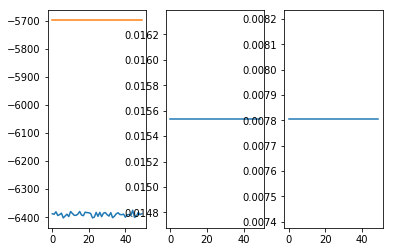

Fold 2:


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [81]:
import torch
import torch.nn as nn
import pickle as pk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


words, sentences, labels, tags_vals, tag2idx = read_data("data/dataset.csv")
data_fold = vectorization(config, sentences, labels, tags_vals, tag2idx)

config['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print('The device is ' + torch.cuda.get_device_name(0)) 

# weight =  np.log(max(count)/count)+mu
# weight = torch.tensor(weight)
# #     weight = None
# model = BuildModel(config, weight)
# model, max_acc, max_f1 = train(config, model, dataloader, if_plot=True)

# pk.dump(model,open('results/model.pkl','wb'))
# predictions, true_labels, eval_loss, eval_accuracy, f1 = test(config, model, valid_dataloader, validation = False)

# print('Cross Validation')
# fold_num = config['fold_num']
# kfold = KFold(fold_num, shuffle=True, random_state=None)
# # enumerate splits
# f = 1
# eval_accuracy_fold = [] 
# f1_fold = []
# model = None
# for train_index, test_index in kfold.split(data_fold[0]):
#     dataloader, count = myDataLoader(data_fold, train_index, test_index)
    
#     weight = torch.tensor(np.log(config['mu']*max(count)/count))
#     print('Fold {}:'.format(f))
#     del model
#     model = BuildModel(config, weight)
#     _, eval_accuracy, f1 = train(config, model, dataloader, if_plot=True, fold_id=f)
#     eval_accuracy_fold.append(eval_accuracy)
#     f1_fold.append(f1)
#     f+=1
# print('accuracy of folds: {}'.format(eval_accuracy_fold))
# print('average accuracy: {}'.format(sum(eval_accuracy_fold)/fold_num))
# print('f1 of folds: {}'.format(f1_fold))
# print('average f1: {}'.format(sum(f1_fold)/fold_num))

# predictions, true_labels, eval_loss, eval_accuracy, f1 = test(model, test_dataloader, validation = False)

The longest sentence has 697 tokens.
The device is GeForce RTX 2080 Ti
Cross Validation
mu= 3
Fold 1:


/home/junliang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 0
Validation loss: 2.6427215933799744
Validation Accuracy: 0.032272132577409504
F1-Score: 0.016571043286125634



/home/junliang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 10
Train loss: 0.011975134367821738
Validation loss: 0.06517420565069187
Validation Accuracy: 0.987352812908853
F1-Score: 0.8962725501344385

Epoch: 20
Train loss: 0.0028659283930513387
Validation loss: 0.07329620725795394
Validation Accuracy: 0.9858264282599215
F1-Score: 0.8932739566387627

Epoch: 30
Train loss: 0.0041833837477800746
Validation loss: 0.06985662086844968
Validation Accuracy: 0.9862625381596162
F1-Score: 0.9062502057523687

The best result: 
Validation Accuracy: 0.9884430876580899, F1-Score: 0.9296320708267645


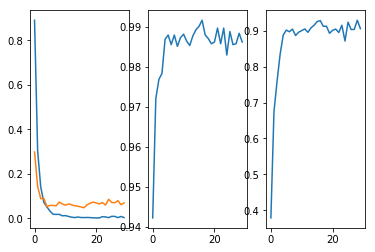

Fold 2:
Epoch: 0
Validation loss: 2.949704736471176
Validation Accuracy: 0.00855891719745223
F1-Score: 0.013736183318626824

Epoch: 10
Train loss: 0.011732669485112032
Validation loss: 0.08607276203110814
Validation Accuracy: 0.9864649681528662
F1-Score: 0.8787534532125088

Epoch: 20
Train loss: 0.004387426933196063
Validation loss: 0.09578375332057476
Validation Accuracy: 0.9872611464968153
F1-Score: 0.8679574708736287

Epoch: 30
Train loss: 0.0029951189421505357
Validation loss: 0.12133287254255265
Validation Accuracy: 0.9836783439490446
F1-Score: 0.8687550805473694

The best result: 
Validation Accuracy: 0.9872611464968153, F1-Score: 0.883775202264133


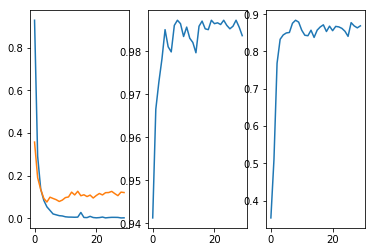

Fold 3:
Epoch: 0
Validation loss: 2.734749585390091
Validation Accuracy: 0.03269069572506287
F1-Score: 0.011891585328711648

Epoch: 10
Train loss: 0.008233956270851195
Validation loss: 0.18130185245536268
Validation Accuracy: 0.9805113160100587
F1-Score: 0.8743645238872702

Epoch: 20
Train loss: 0.004872993661168342
Validation loss: 0.15256883949041367
Validation Accuracy: 0.9815590947191953
F1-Score: 0.8871749854876907

Epoch: 30
Train loss: 0.004550248880210953
Validation loss: 0.19018156826496124
Validation Accuracy: 0.980092204526404
F1-Score: 0.8827983385341137

The best result: 
Validation Accuracy: 0.9830259849119866, F1-Score: 0.9017036707930163


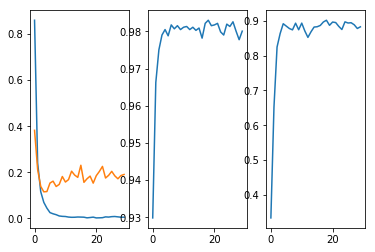

Fold 4:
Epoch: 0
Validation loss: 2.7952676713466644
Validation Accuracy: 0.012174989682212133
F1-Score: 0.006962304555247279

Epoch: 10
Train loss: 0.007499813144871344
Validation loss: 0.15815872885286808
Validation Accuracy: 0.9764754436648783
F1-Score: 0.7959029433190251

Epoch: 20
Train loss: 0.004526430843786026
Validation loss: 0.15968022821471095
Validation Accuracy: 0.9787453569954602
F1-Score: 0.7984177372126117

Epoch: 30
Train loss: 0.0037073303673726818
Validation loss: 0.17477650893852115
Validation Accuracy: 0.9785390012381345
F1-Score: 0.8032657850970514

The best result: 
Validation Accuracy: 0.9781262897234833, F1-Score: 0.8640451489511883


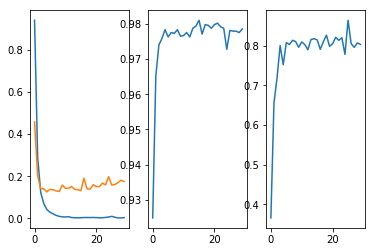

Fold 5:
Epoch: 0
Validation loss: 2.835554212331772
Validation Accuracy: 0.013089005235602094
F1-Score: 0.010592076705750316

Epoch: 10
Train loss: 0.01116261505521834
Validation loss: 0.20528497453778982
Validation Accuracy: 0.9727312390924956
F1-Score: 0.7740983387974437

Epoch: 20
Train loss: 0.0031656262658846875
Validation loss: 0.20245676301419735
Validation Accuracy: 0.9764397905759162
F1-Score: 0.8213129646979795

Epoch: 30
Train loss: 0.004083801731273221
Validation loss: 0.17504511401057243
Validation Accuracy: 0.9794938917975567
F1-Score: 0.8522955734632478

The best result: 
Validation Accuracy: 0.9768760907504364, F1-Score: 0.8691476939072756


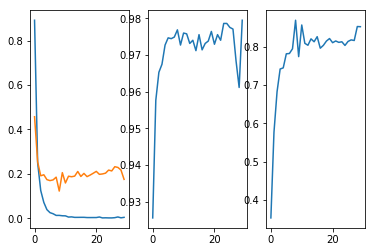

accuracy of folds: [0.9884430876580899, 0.9872611464968153, 0.9830259849119866, 0.9781262897234833, 0.9768760907504364]
average accuracy: 0.9827465199081622
f1 of folds: [0.9296320708267645, 0.883775202264133, 0.9017036707930163, 0.8640451489511883, 0.8691476939072756]
average f1: 0.8896607573484756
mu= 4
Fold 1:
Epoch: 0
Validation loss: 2.626032441854477
Validation Accuracy: 0.054513737461840385
F1-Score: 0.013685693747468055

Epoch: 10
Train loss: 0.008840756820670018
Validation loss: 0.06749830175249372
Validation Accuracy: 0.9860444832097689
F1-Score: 0.8966785587189207

Epoch: 20
Train loss: 0.0024452358814111602
Validation loss: 0.07949807167460676
Validation Accuracy: 0.9877889228085478
F1-Score: 0.9249413381334487

Epoch: 30
Train loss: 0.001514545505051501
Validation loss: 0.08219670982907701
Validation Accuracy: 0.9884430876580899
F1-Score: 0.9314544668784902

The best result: 
Validation Accuracy: 0.9888791975577845, F1-Score: 0.932273057608858


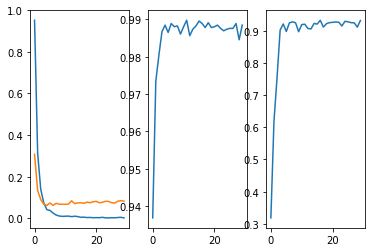

Fold 2:
Epoch: 0
Validation loss: 2.6962247788906097
Validation Accuracy: 0.05871815286624204
F1-Score: 0.059804453605350735

Epoch: 10
Train loss: 0.016346932419886193
Validation loss: 0.08476773975417018
Validation Accuracy: 0.98546974522293
F1-Score: 0.8860931800829083

Epoch: 20
Train loss: 0.0040014647568265595
Validation loss: 0.1017667637206614
Validation Accuracy: 0.9880573248407644
F1-Score: 0.879629068376089

Epoch: 30
Train loss: 0.003889079457925012
Validation loss: 0.08316200110130012
Validation Accuracy: 0.9856687898089171
F1-Score: 0.8740623150871323

The best result: 
Validation Accuracy: 0.9876592356687898, F1-Score: 0.8942051023139607


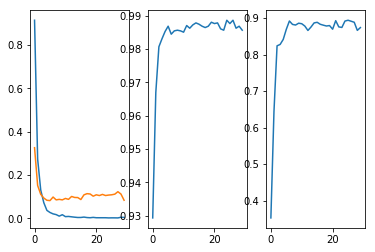

Fold 3:
Epoch: 0
Validation loss: 2.8939694464206696
Validation Accuracy: 0.007334450963956412
F1-Score: 0.01995405650756954

Epoch: 10
Train loss: 0.009077952763376137
Validation loss: 0.13891713041812181
Validation Accuracy: 0.980092204526404
F1-Score: 0.8670008963749771

Epoch: 20
Train loss: 0.0037492183250530313
Validation loss: 0.1447915555909276
Validation Accuracy: 0.9809304274937133
F1-Score: 0.8832821276602237

Epoch: 30
Train loss: 0.003265580664932107
Validation loss: 0.1865260493941605
Validation Accuracy: 0.9794635373009221
F1-Score: 0.857457799751606

The best result: 
Validation Accuracy: 0.9809304274937133, F1-Score: 0.8832821276602237


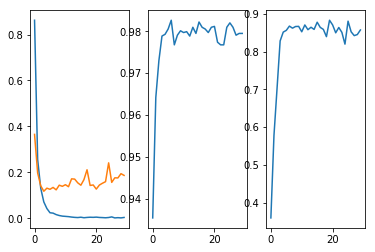

Fold 4:
Epoch: 0
Validation loss: 2.7542624473571777
Validation Accuracy: 0.007222451506397029
F1-Score: 0.004446567209986952

Epoch: 10
Train loss: 0.010356450523249804
Validation loss: 0.1412769677117467
Validation Accuracy: 0.9764754436648783
F1-Score: 0.7817737156654234

Epoch: 20
Train loss: 0.0020215544345167777
Validation loss: 0.14217268954962492
Validation Accuracy: 0.9795707800247627
F1-Score: 0.8818513865379494

Epoch: 30
Train loss: 0.00410468865011353
Validation loss: 0.1621015202254057
Validation Accuracy: 0.9795707800247627
F1-Score: 0.8181799365930337

The best result: 
Validation Accuracy: 0.9795707800247627, F1-Score: 0.8818513865379494


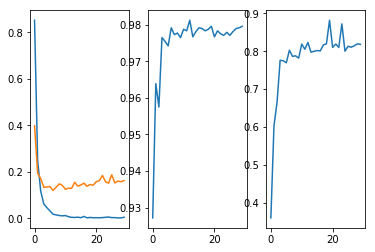

Fold 5:
Epoch: 0
Validation loss: 2.889184683561325
Validation Accuracy: 0.015270506108202443
F1-Score: 0.00888391756296622

Epoch: 10
Train loss: 0.011729088219969224
Validation loss: 0.1556625859811902
Validation Accuracy: 0.9768760907504364
F1-Score: 0.7922173065506155

Epoch: 20
Train loss: 0.003729052767933657
Validation loss: 0.19257972948253155
Validation Accuracy: 0.9760034904013961
F1-Score: 0.8070652033149468

Epoch: 30
Train loss: 0.00271955346785641
Validation loss: 0.20692541869357228
Validation Accuracy: 0.9790575916230366
F1-Score: 0.7886208921712512

The best result: 
Validation Accuracy: 0.9757853403141361, F1-Score: 0.8540982145311017


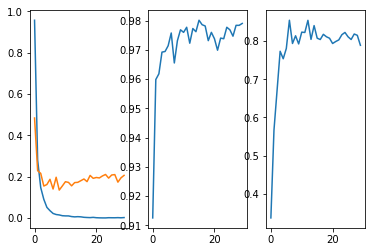

accuracy of folds: [0.9888791975577845, 0.9876592356687898, 0.9809304274937133, 0.9795707800247627, 0.9757853403141361]
average accuracy: 0.9825649962118372
f1 of folds: [0.932273057608858, 0.8942051023139607, 0.8832821276602237, 0.8818513865379494, 0.8540982145311017]
average f1: 0.8891419777304186
mu= 5
Fold 1:
Epoch: 0
Validation loss: 2.6799744367599487
Validation Accuracy: 0.019188835586567816
F1-Score: 0.01757958691083991

Epoch: 10
Train loss: 0.009119558058834324
Validation loss: 0.06340949355944758
Validation Accuracy: 0.9836458787614479
F1-Score: 0.8978522171327685

Epoch: 20
Train loss: 0.0019373814148517946
Validation loss: 0.04713238916701812
Validation Accuracy: 0.9921500218054949
F1-Score: 0.944009185444686

Epoch: 30
Train loss: 0.0037203018873697147
Validation loss: 0.05943652756832307
Validation Accuracy: 0.9893153074574793
F1-Score: 0.9408453576306633

The best result: 
Validation Accuracy: 0.9908416921064108, F1-Score: 0.9447433043072124


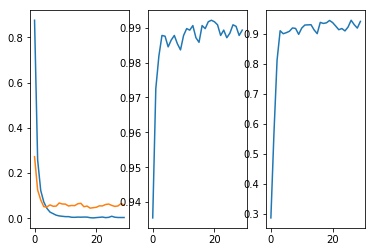

Fold 2:
Epoch: 0
Validation loss: 2.695419669151306
Validation Accuracy: 0.029856687898089172
F1-Score: 0.014669848078527725

Epoch: 10
Train loss: 0.010315894909823934
Validation loss: 0.08116472000256181
Validation Accuracy: 0.9868630573248408
F1-Score: 0.8985851401491657

Epoch: 20
Train loss: 0.0036925228758870315
Validation loss: 0.0968244094401598
Validation Accuracy: 0.9864649681528662
F1-Score: 0.8713330959326101

Epoch: 30
Train loss: 0.005090877253678627
Validation loss: 0.09743286855518818
Validation Accuracy: 0.9872611464968153
F1-Score: 0.8729208652349632

The best result: 
Validation Accuracy: 0.9868630573248408, F1-Score: 0.8985851401491657


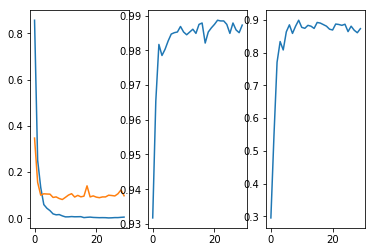

Fold 3:
Epoch: 0
Validation loss: 2.7553619146347046
Validation Accuracy: 0.06768650461022632
F1-Score: 0.018078175265324764

Epoch: 10
Train loss: 0.008047527947928757
Validation loss: 0.1353248506784439
Validation Accuracy: 0.9798826487845766
F1-Score: 0.8601908561885889

Epoch: 20
Train loss: 0.0028224689633740735
Validation loss: 0.17434928193688393
Validation Accuracy: 0.9748533109807209
F1-Score: 0.844412784516154

Epoch: 30
Train loss: 0.0025122337819387516
Validation loss: 0.16411981964483857
Validation Accuracy: 0.9775775356244761
F1-Score: 0.8808904632024039

The best result: 
Validation Accuracy: 0.9775775356244761, F1-Score: 0.8808904632024039


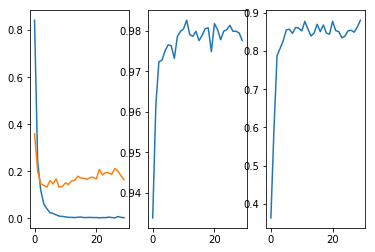

Fold 4:
Epoch: 0
Validation loss: 2.439172625541687
Validation Accuracy: 0.33408997111019395
F1-Score: 0.04228745471726396

Epoch: 10
Train loss: 0.005965096453049531
Validation loss: 0.11811504419893026
Validation Accuracy: 0.9775072224515065
F1-Score: 0.8134928135539549

Epoch: 20
Train loss: 0.0036730685397439325
Validation loss: 0.13611711817793548
Validation Accuracy: 0.977713578208832
F1-Score: 0.8056588261586888

Epoch: 30
Train loss: 0.007083013730395275
Validation loss: 0.16948895249515772
Validation Accuracy: 0.977713578208832
F1-Score: 0.7973250944800063

The best result: 
Validation Accuracy: 0.9773008666941808, F1-Score: 0.8214532448145613


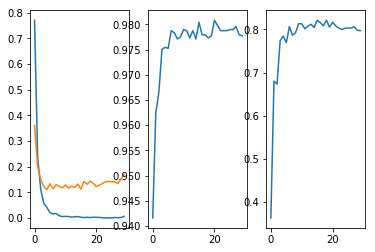

Fold 5:
Epoch: 0
Validation loss: 2.5141704976558685
Validation Accuracy: 0.2006980802792321
F1-Score: 0.03352955578538976

Epoch: 10
Train loss: 0.009269820790116986
Validation loss: 0.18762773368507624
Validation Accuracy: 0.9727312390924956
F1-Score: 0.7926324088573238

Epoch: 20
Train loss: 0.002960435510613024
Validation loss: 0.17923009116202593
Validation Accuracy: 0.9773123909249564
F1-Score: 0.7837777138503756

Epoch: 30
Train loss: 0.002800798637326807
Validation loss: 0.20607918500900269
Validation Accuracy: 0.9808027923211169
F1-Score: 0.8126010238625312

The best result: 
Validation Accuracy: 0.9792757417102966, F1-Score: 0.8389366000188218


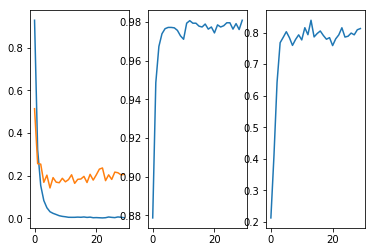

accuracy of folds: [0.9908416921064108, 0.9868630573248408, 0.9775775356244761, 0.9773008666941808, 0.9792757417102966]
average accuracy: 0.9823717786920412
f1 of folds: [0.9447433043072124, 0.8985851401491657, 0.8808904632024039, 0.8214532448145613, 0.8389366000188218]
average f1: 0.8769217504984329
mu= 6
Fold 1:
Epoch: 0
Validation loss: 2.672543942928314
Validation Accuracy: 0.04753597906672481
F1-Score: 0.017038196471919627

Epoch: 10
Train loss: 0.009847953197701523
Validation loss: 0.05330158369906712
Validation Accuracy: 0.9880069777583951
F1-Score: 0.9233281064910993

Epoch: 20
Train loss: 0.002990549218763287
Validation loss: 0.05483779172209324
Validation Accuracy: 0.9890972525076319
F1-Score: 0.9291040024902052

Epoch: 30
Train loss: 0.004776740448627
Validation loss: 0.0752668715085747
Validation Accuracy: 0.9864805931094636
F1-Score: 0.9132680020186199

The best result: 
Validation Accuracy: 0.9882250327082425, F1-Score: 0.9314437110557369


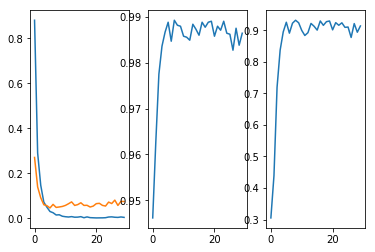

Fold 2:
Epoch: 0
Validation loss: 2.7409213185310364
Validation Accuracy: 0.012539808917197453
F1-Score: 0.0053340630281124846

Epoch: 10
Train loss: 0.008522699986739705
Validation loss: 0.08002162934280932
Validation Accuracy: 0.9860668789808917
F1-Score: 0.8637373807940443

Epoch: 20
Train loss: 0.0052750339799483
Validation loss: 0.08987742179306224
Validation Accuracy: 0.9846735668789809
F1-Score: 0.8601180997362566

Epoch: 30
Train loss: 0.0029830325850828863
Validation loss: 0.0918402953830082
Validation Accuracy: 0.9874601910828026
F1-Score: 0.8663752572752154

The best result: 
Validation Accuracy: 0.9894506369426752, F1-Score: 0.8961497246188136


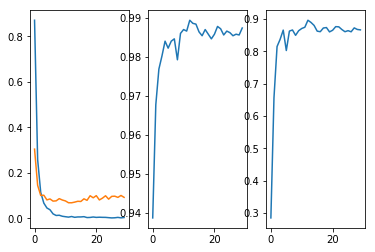

Fold 3:
Epoch: 0
Validation loss: 2.7601503133773804
Validation Accuracy: 0.02556580050293378
F1-Score: 0.010872976425003381

Epoch: 10
Train loss: 0.00655310235839958
Validation loss: 0.13594716694206
Validation Accuracy: 0.9792539815590947
F1-Score: 0.8825223387763987

Epoch: 20
Train loss: 0.0018278484310333928
Validation loss: 0.14538508001714945
Validation Accuracy: 0.9811399832355406
F1-Score: 0.8730313660715053

Epoch: 30
Train loss: 0.0009083615936106071
Validation loss: 0.1571863880380988
Validation Accuracy: 0.980092204526404
F1-Score: 0.8706889692044941

The best result: 
Validation Accuracy: 0.9842833193629505, F1-Score: 0.9133784792562942


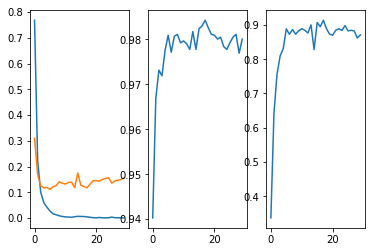

Fold 4:
Epoch: 0
Validation loss: 2.5676370561122894
Validation Accuracy: 0.1306231943871234
F1-Score: 0.02851930723995259

Epoch: 10
Train loss: 0.011039886134676635
Validation loss: 0.11603371938690543
Validation Accuracy: 0.9793644242674371
F1-Score: 0.799605048805549

Epoch: 20
Train loss: 0.0029726001531040916
Validation loss: 0.15656378399580717
Validation Accuracy: 0.9764754436648783
F1-Score: 0.7948710384165777

Epoch: 30
Train loss: 0.004473045009459989
Validation loss: 0.1359488358721137
Validation Accuracy: 0.9791580685101114
F1-Score: 0.8176226551007841

The best result: 
Validation Accuracy: 0.9808089145687164, F1-Score: 0.8239975173449108


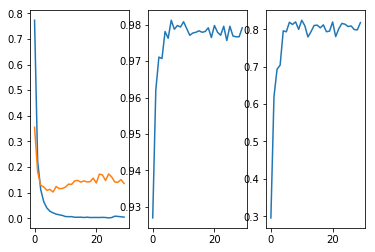

Fold 5:
Epoch: 0
Validation loss: 2.7227017879486084
Validation Accuracy: 0.025087260034904014
F1-Score: 0.012835633180584451

Epoch: 10
Train loss: 0.009875379463968178
Validation loss: 0.16961670760065317
Validation Accuracy: 0.9727312390924956
F1-Score: 0.844134074160904

Epoch: 20
Train loss: 0.004568641070121279
Validation loss: 0.19040861167013645
Validation Accuracy: 0.9764397905759162
F1-Score: 0.7941734689676561

Epoch: 30
Train loss: 0.0025868624487581354
Validation loss: 0.24099702760577202
Validation Accuracy: 0.9773123909249564
F1-Score: 0.8355795989262217

The best result: 
Validation Accuracy: 0.9727312390924956, F1-Score: 0.844134074160904


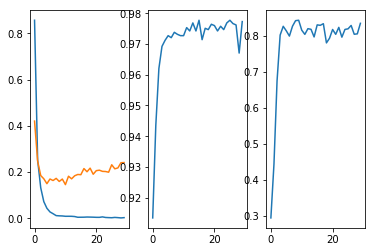

accuracy of folds: [0.9882250327082425, 0.9894506369426752, 0.9842833193629505, 0.9808089145687164, 0.9727312390924956]
average accuracy: 0.9830998285350161
f1 of folds: [0.9314437110557369, 0.8961497246188136, 0.9133784792562942, 0.8239975173449108, 0.844134074160904]
average f1: 0.8818207012873319
mu= 7
Fold 1:
Epoch: 0
Validation loss: 2.811314582824707
Validation Accuracy: 0.022241604884430877
F1-Score: 0.019067864613910402

Epoch: 10
Train loss: 0.010343083529733121
Validation loss: 0.06212473540654173
Validation Accuracy: 0.9847361535106847
F1-Score: 0.8810022329350764

Epoch: 20
Train loss: 0.0034552955641023193
Validation loss: 0.06666847423912259
Validation Accuracy: 0.987352812908853
F1-Score: 0.9219988128684092

Epoch: 30
Train loss: 0.004936557810287923
Validation loss: 0.08633623541027191
Validation Accuracy: 0.9816833842128216
F1-Score: 0.8461474943402275

The best result: 
Validation Accuracy: 0.9888791975577845, F1-Score: 0.9400534861576807


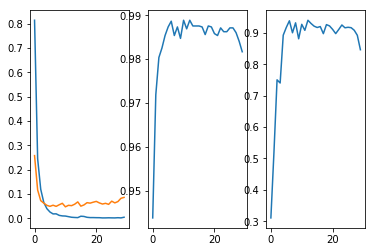

Fold 2:
Epoch: 0
Validation loss: 2.6511546969413757
Validation Accuracy: 0.06687898089171974
F1-Score: 0.026079623624646765

Epoch: 10
Train loss: 0.010813115905815114
Validation loss: 0.09122289624065161
Validation Accuracy: 0.9826831210191083
F1-Score: 0.8591901549786835

Epoch: 20
Train loss: 0.004617036322209363
Validation loss: 0.1004096120595932
Validation Accuracy: 0.9852707006369427
F1-Score: 0.8533409620687208

Epoch: 30
Train loss: 0.002916994768505295
Validation loss: 0.09384900279110298
Validation Accuracy: 0.9858678343949044
F1-Score: 0.8591943955629602

The best result: 
Validation Accuracy: 0.9864649681528662, F1-Score: 0.8840343544951786


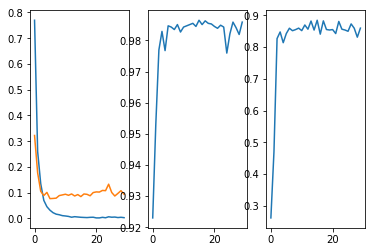

Fold 3:
Epoch: 0
Validation loss: 2.739191621541977
Validation Accuracy: 0.028499580888516344
F1-Score: 0.014779284536032054

Epoch: 10
Train loss: 0.009283949019542584
Validation loss: 0.1297895829193294
Validation Accuracy: 0.9784157585917854
F1-Score: 0.8492673402900741

Epoch: 20
Train loss: 0.004697254007138932
Validation loss: 0.14702617330476642
Validation Accuracy: 0.9805113160100587
F1-Score: 0.863768561699736

Epoch: 30
Train loss: 0.003429090589634143
Validation loss: 0.14641027199104428
Validation Accuracy: 0.9803017602682313
F1-Score: 0.8716002295294571

The best result: 
Validation Accuracy: 0.9794635373009221, F1-Score: 0.8981849021130945


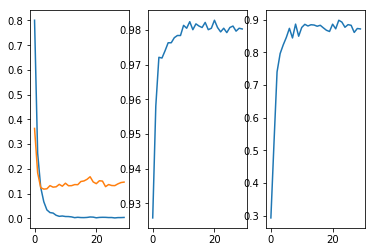

Fold 4:
Epoch: 0
Validation loss: 2.6861726343631744
Validation Accuracy: 0.026826248452331822
F1-Score: 0.009101938769541481

Epoch: 10
Train loss: 0.011271855390320221
Validation loss: 0.11604919703677297
Validation Accuracy: 0.979983491539414
F1-Score: 0.8148678334016469

Epoch: 20
Train loss: 0.001925763268567001
Validation loss: 0.14565478824079037
Validation Accuracy: 0.9787453569954602
F1-Score: 0.8153978389409756

Epoch: 30
Train loss: 0.004221968340182987
Validation loss: 0.12458108318969607
Validation Accuracy: 0.9803962030540652
F1-Score: 0.8085329814094101

The best result: 
Validation Accuracy: 0.9810152703260421, F1-Score: 0.8746170086729573


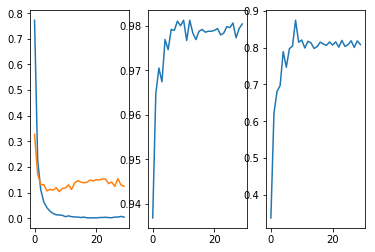

Fold 5:
Epoch: 0
Validation loss: 2.7084195613861084
Validation Accuracy: 0.026832460732984294
F1-Score: 0.016448934051620318

Epoch: 10
Train loss: 0.0072409358147221305
Validation loss: 0.17653941828757524
Validation Accuracy: 0.9722949389179756
F1-Score: 0.796319330521579

Epoch: 20
Train loss: 0.0033762397652026266
Validation loss: 0.18870456516742706
Validation Accuracy: 0.9794938917975567
F1-Score: 0.8072798564107954

Epoch: 30
Train loss: 0.002220859557079772
Validation loss: 0.19562290608882904
Validation Accuracy: 0.9775305410122164
F1-Score: 0.8361160557401447

The best result: 
Validation Accuracy: 0.9790575916230366, F1-Score: 0.8828842758682107


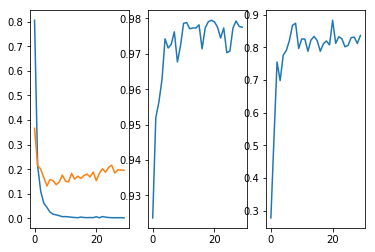

accuracy of folds: [0.9888791975577845, 0.9864649681528662, 0.9794635373009221, 0.9810152703260421, 0.9790575916230366]
average accuracy: 0.9829761129921304
f1 of folds: [0.9400534861576807, 0.8840343544951786, 0.8981849021130945, 0.8746170086729573, 0.8828842758682107]
average f1: 0.8959548054614244
mu= 8
Fold 1:
Epoch: 0
Validation loss: 2.651633769273758
Validation Accuracy: 0.02442215438290449
F1-Score: 0.00697771669181639

Epoch: 10
Train loss: 0.014960867414871851
Validation loss: 0.053266604081727564
Validation Accuracy: 0.9862625381596162
F1-Score: 0.9022280523471539

Epoch: 20
Train loss: 0.003556544145491595
Validation loss: 0.05246772406644595
Validation Accuracy: 0.9871347579590056
F1-Score: 0.9154052131714777

Epoch: 30
Train loss: 0.004420900918194093
Validation loss: 0.0702082031621103
Validation Accuracy: 0.9871347579590056
F1-Score: 0.9161535017044199

The best result: 
Validation Accuracy: 0.9908416921064108, F1-Score: 0.9498557818636388


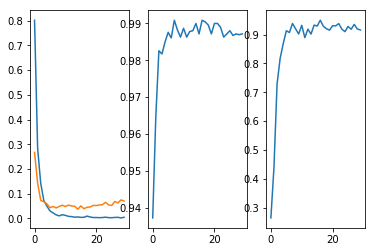

Fold 2:
Epoch: 0
Validation loss: 2.66043159365654
Validation Accuracy: 0.029060509554140128
F1-Score: 0.013556177239440895

Epoch: 10
Train loss: 0.010395391723917177
Validation loss: 0.0829829869326204
Validation Accuracy: 0.9814888535031847
F1-Score: 0.8393868520209884

Epoch: 20
Train loss: 0.00472015788157781
Validation loss: 0.08658024505712092
Validation Accuracy: 0.9864649681528662
F1-Score: 0.8589712859624167

Epoch: 30
Train loss: 0.003923501071403735
Validation loss: 0.09215351124294102
Validation Accuracy: 0.9858678343949044
F1-Score: 0.8735594118034365

The best result: 
Validation Accuracy: 0.9852707006369427, F1-Score: 0.883603834224746


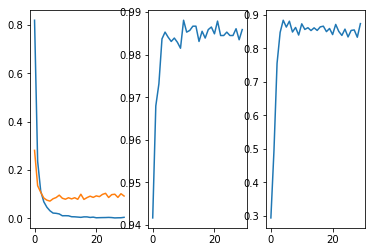

Fold 3:
Epoch: 0
Validation loss: 2.652422219514847
Validation Accuracy: 0.06873428331936295
F1-Score: 0.03500237927677268

Epoch: 10
Train loss: 0.00834218212015306
Validation loss: 0.11801946978084743
Validation Accuracy: 0.9796730930427494
F1-Score: 0.8632441118649845

Epoch: 20
Train loss: 0.0011342497911149016
Validation loss: 0.14581517316401005
Validation Accuracy: 0.9817686504610227
F1-Score: 0.880743145081242

Epoch: 30
Train loss: 0.007919003571926927
Validation loss: 0.11708513740450144
Validation Accuracy: 0.9832355406538139
F1-Score: 0.88641343424072

The best result: 
Validation Accuracy: 0.9832355406538139, F1-Score: 0.9016894916506819


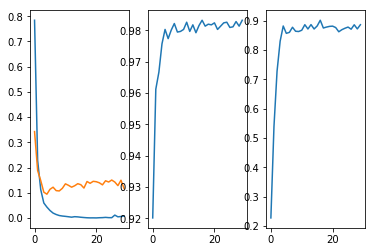

Fold 4:
Epoch: 0
Validation loss: 2.6102031767368317
Validation Accuracy: 0.10482872472141973
F1-Score: 0.0203634183606548

Epoch: 10
Train loss: 0.009013326085793475
Validation loss: 0.10705758072435856
Validation Accuracy: 0.9783326454808089
F1-Score: 0.8024114459011236

Epoch: 20
Train loss: 0.004389975774878015
Validation loss: 0.11989239673130214
Validation Accuracy: 0.9820470491126703
F1-Score: 0.8135133192395142

Epoch: 30
Train loss: 0.0026754410074014837
Validation loss: 0.16341679962351918
Validation Accuracy: 0.9768881551795295
F1-Score: 0.7996393281994758

The best result: 
Validation Accuracy: 0.9793644242674371, F1-Score: 0.8570886524249871


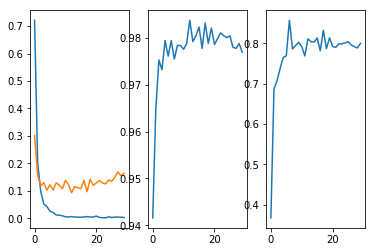

Fold 5:
Epoch: 0
Validation loss: 2.5258789658546448
Validation Accuracy: 0.1431064572425829
F1-Score: 0.03305717925397879

Epoch: 10
Train loss: 0.009249347626852493
Validation loss: 0.17908765841275454
Validation Accuracy: 0.9718586387434555
F1-Score: 0.8132803471504074

Epoch: 20
Train loss: 0.004579804628156126
Validation loss: 0.16993021313101053
Validation Accuracy: 0.974912739965096
F1-Score: 0.8001097147259535

Epoch: 30
Train loss: 0.004109428207933282
Validation loss: 0.21007909066975117
Validation Accuracy: 0.9738219895287958
F1-Score: 0.7759015582498286

The best result: 
Validation Accuracy: 0.9775305410122164, F1-Score: 0.863565246899793


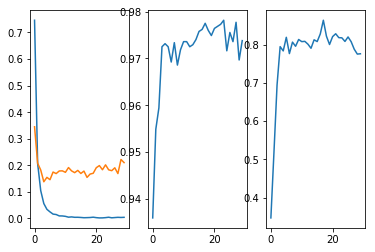

accuracy of folds: [0.9908416921064108, 0.9852707006369427, 0.9832355406538139, 0.9793644242674371, 0.9775305410122164]
average accuracy: 0.9832485797353641
f1 of folds: [0.9498557818636388, 0.883603834224746, 0.9016894916506819, 0.8570886524249871, 0.863565246899793]
average f1: 0.8911606014127692
mu= 9
Fold 1:
Epoch: 0
Validation loss: 2.671194404363632
Validation Accuracy: 0.027474923680767552
F1-Score: 0.01405772565974624

Epoch: 10
Train loss: 0.008040583576075733
Validation loss: 0.048573868414678145
Validation Accuracy: 0.9895333624073267
F1-Score: 0.9338166413490374

Epoch: 20
Train loss: 0.0029906041163485497
Validation loss: 0.04521677844968508
Validation Accuracy: 0.9912778020061055
F1-Score: 0.9336169651145112

Epoch: 30
Train loss: 0.0016695400525350123
Validation loss: 0.05293721439829824
Validation Accuracy: 0.9908416921064108
F1-Score: 0.9394178032456614

The best result: 
Validation Accuracy: 0.9917139119058003, F1-Score: 0.9534535077038042


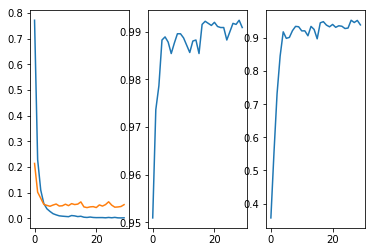

Fold 2:
Epoch: 0
Validation loss: 2.4356913566589355
Validation Accuracy: 0.29080414012738853
F1-Score: 0.042721330372622025

Epoch: 10
Train loss: 0.007224809681065381
Validation loss: 0.08289755182340741
Validation Accuracy: 0.9858678343949044
F1-Score: 0.8669386650533325

Epoch: 20
Train loss: 0.004787424435683836
Validation loss: 0.08344465540722013
Validation Accuracy: 0.9860668789808917
F1-Score: 0.8671705252424596

Epoch: 30
Train loss: 0.002952341240112825
Validation loss: 0.08970477059483528
Validation Accuracy: 0.9868630573248408
F1-Score: 0.8691874418638661

The best result: 
Validation Accuracy: 0.9874601910828026, F1-Score: 0.8897269154502955


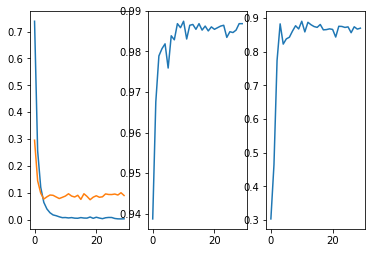

Fold 3:
Epoch: 0
Validation loss: 2.3599628508090973
Validation Accuracy: 0.42896060352053644
F1-Score: 0.06310206629007153

Epoch: 10
Train loss: 0.007778843891962121
Validation loss: 0.13201151648536325
Validation Accuracy: 0.9777870913663035
F1-Score: 0.8621857606929028

Epoch: 20
Train loss: 0.002907455019885674
Validation loss: 0.19396204920485616
Validation Accuracy: 0.9771584241408214
F1-Score: 0.8679591913032626

Epoch: 30
Train loss: 0.003328997059725225
Validation loss: 0.11068472312763333
Validation Accuracy: 0.9803017602682313
F1-Score: 0.890025560908372

The best result: 
Validation Accuracy: 0.9811399832355406, F1-Score: 0.89961321915335


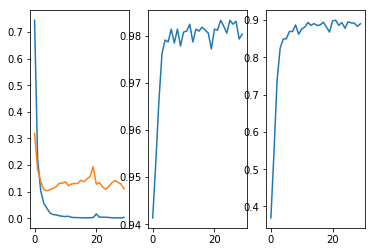

Fold 4:
Epoch: 0
Validation loss: 2.736066073179245
Validation Accuracy: 0.034874122988031366
F1-Score: 0.01668113982567818

Epoch: 10
Train loss: 0.00747723081925263
Validation loss: 0.13014760077930987
Validation Accuracy: 0.9787453569954602
F1-Score: 0.7931349496388772

Epoch: 20
Train loss: 0.0024987552256789058
Validation loss: 0.14762842655181885
Validation Accuracy: 0.9785390012381345
F1-Score: 0.7896879365514268

Epoch: 30
Train loss: 0.002348389700637199
Validation loss: 0.14795344858430326
Validation Accuracy: 0.9770945109368552
F1-Score: 0.8214057344977929

The best result: 
Validation Accuracy: 0.9787453569954602, F1-Score: 0.854076579641864


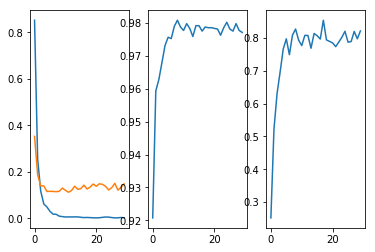

Fold 5:
Epoch: 0
Validation loss: 2.557928651571274
Validation Accuracy: 0.12107329842931937
F1-Score: 0.03023825369297232

Epoch: 10
Train loss: 0.008439155004452914
Validation loss: 0.17040051147341728
Validation Accuracy: 0.9722949389179756
F1-Score: 0.7590860028121836

Epoch: 20
Train loss: 0.004754499367360647
Validation loss: 0.1565409181639552
Validation Accuracy: 0.9766579406631762
F1-Score: 0.798189110342013

Epoch: 30
Train loss: 0.0013257347057030226
Validation loss: 0.1854608617722988
Validation Accuracy: 0.9770942408376964
F1-Score: 0.8289682589643697

The best result: 
Validation Accuracy: 0.9757853403141361, F1-Score: 0.8684512623126373


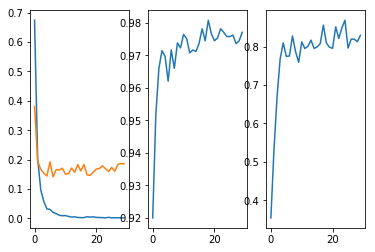

accuracy of folds: [0.9917139119058003, 0.9874601910828026, 0.9811399832355406, 0.9787453569954602, 0.9757853403141361]
average accuracy: 0.9829689567067479
f1 of folds: [0.9534535077038042, 0.8897269154502955, 0.89961321915335, 0.854076579641864, 0.8684512623126373]
average f1: 0.8930642968523902


[(3, 0.9827465199081622, 0.8896607573484756),
 (4, 0.9825649962118372, 0.8891419777304186),
 (5, 0.9823717786920412, 0.8769217504984329),
 (6, 0.9830998285350161, 0.8818207012873319),
 (7, 0.9829761129921304, 0.8959548054614244),
 (8, 0.9832485797353641, 0.8911606014127692),
 (9, 0.9829689567067479, 0.8930642968523902)]

<Figure size 432x288 with 0 Axes>

In [8]:
import torch
import torch.nn as nn
import pickle as pk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('once')

words, sentences, labels, tags_vals, tag2idx = read_data("data/dataset.csv")
data_fold = vectorization(config, sentences, labels, tags_vals, tag2idx)

config['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print('The device is ' + torch.cuda.get_device_name(0)) 

fold_num = config['fold_num']
kfold = KFold(fold_num, shuffle=True, random_state=1)


print('Cross Validation')
config['epochs']=30
acc_list = []
f1_list = []
for mu in range(3,10):
    print('mu=',mu)
    f = 1
    eval_accuracy_fold = [] 
    f1_fold = []
    model = None
    # enumerate splits
    for train_index, test_index in kfold.split(data_fold[0]):
        dataloader, count = myDataLoader(data_fold, train_index, test_index)

        weight =  np.log(max(count)/count)+mu
        weight = torch.tensor(weight)
        print('Fold {}:'.format(f))
        del model
        model = BuildModel(config, weight)
        _, eval_accuracy, f1 = train(config, model, dataloader, if_plot=True, fold_id=f)
        eval_accuracy_fold.append(eval_accuracy)
        f1_fold.append(f1)
        f+=1
    print('accuracy of folds: {}'.format(eval_accuracy_fold))
    print('average accuracy: {}'.format(sum(eval_accuracy_fold)/fold_num))
    print('f1 of folds: {}'.format(f1_fold))
    print('average f1: {}'.format(sum(f1_fold)/fold_num))
    acc_list.append(sum(eval_accuracy_fold)/fold_num)
    f1_list.append(sum(f1_fold)/fold_num)
list(zip(range(3,10),acc_list,f1_list))

# predictions, true_labels, eval_loss, eval_accuracy, f1 = test(model, test_dataloader, validation = False)

Cross Validation
mu= 0.0
Fold 1:
Epoch: 0
Validation loss: 2.653542250394821
Validation Accuracy: 0.11208024422154383
F1-Score: 0.022306913887577322

Epoch: 10
Train loss: 0.013688808567045877
Validation loss: 0.06364985622349195
Validation Accuracy: 0.9910597470562582
F1-Score: 0.9428964651202241

Epoch: 20
Train loss: 0.005424155820704376
Validation loss: 0.06899307505591423
Validation Accuracy: 0.9882250327082425
F1-Score: 0.9204800545169223

Epoch: 30
Train loss: 0.0029674656233207013
Validation loss: 0.09838982017208764
Validation Accuracy: 0.9880069777583951
F1-Score: 0.8903720349574744

The best result: 
Validation Accuracy: 0.9910597470562582, F1-Score: 0.9428964651202241


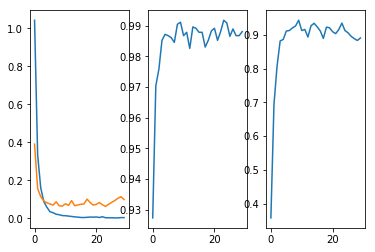

Fold 2:
Epoch: 0
Validation loss: 2.745315968990326
Validation Accuracy: 0.039211783439490444
F1-Score: 0.01345703990716989

Epoch: 10
Train loss: 0.012879585459207496
Validation loss: 0.10532510152552277
Validation Accuracy: 0.9868630573248408
F1-Score: 0.8815809033373134

Epoch: 20
Train loss: 0.004098225427636256
Validation loss: 0.12717065287870355
Validation Accuracy: 0.9866640127388535
F1-Score: 0.872919274865407

Epoch: 30
Train loss: 0.0031712048939274004
Validation loss: 0.15308306831866503
Validation Accuracy: 0.9874601910828026
F1-Score: 0.87873251111294

The best result: 
Validation Accuracy: 0.9906449044585988, F1-Score: 0.9151593535598465


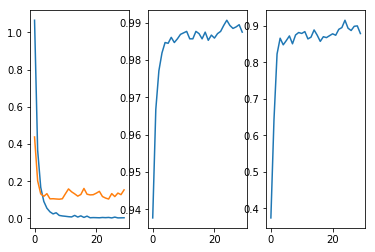

Fold 3:
Epoch: 0
Validation loss: 2.621976315975189
Validation Accuracy: 0.06768650461022632
F1-Score: 0.019803400696494982

Epoch: 10
Train loss: 0.011383747321087868
Validation loss: 0.2262102491222322
Validation Accuracy: 0.9803017602682313
F1-Score: 0.8810284695681732

Epoch: 20
Train loss: 0.007757397653767839
Validation loss: 0.21824336796998978
Validation Accuracy: 0.9805113160100587
F1-Score: 0.8951868587406604

Epoch: 30
Train loss: 0.0023683967262816924
Validation loss: 0.22760125901550055
Validation Accuracy: 0.9788348700754401
F1-Score: 0.8736629811364688

The best result: 
Validation Accuracy: 0.9798826487845766, F1-Score: 0.8993075499358272


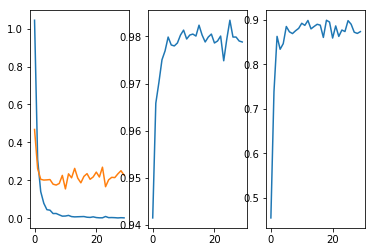

Fold 4:
Epoch: 0
Validation loss: 2.5637309551239014
Validation Accuracy: 0.09946347503095336
F1-Score: 0.03569479372851508

Epoch: 10
Train loss: 0.010779848066158592
Validation loss: 0.19187046959996223
Validation Accuracy: 0.9785390012381345
F1-Score: 0.81599774926193

Epoch: 20
Train loss: 0.0019072126810594152
Validation loss: 0.20251668081618845
Validation Accuracy: 0.9791580685101114
F1-Score: 0.8042035936798039

Epoch: 30
Train loss: 0.002515420065416644
Validation loss: 0.20395378302782774
Validation Accuracy: 0.9746182418489476
F1-Score: 0.796913125381307

The best result: 
Validation Accuracy: 0.9785390012381345, F1-Score: 0.8228883780586927


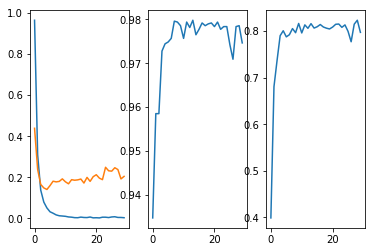

Fold 5:
Epoch: 0
Validation loss: 2.6683996617794037
Validation Accuracy: 0.024214659685863876
F1-Score: 0.011272293000541096

Epoch: 10
Train loss: 0.020370562615183493
Validation loss: 0.22156788874417543
Validation Accuracy: 0.9670593368237347
F1-Score: 0.8287767217400057

Epoch: 20
Train loss: 0.004312129619453723
Validation loss: 0.2507450617849827
Validation Accuracy: 0.9694589877835951
F1-Score: 0.8410782785539456

Epoch: 30
Train loss: 0.0060136057989439
Validation loss: 0.35074235312640667
Validation Accuracy: 0.9738219895287958
F1-Score: 0.8179256968302142

The best result: 
Validation Accuracy: 0.9755671902268761, F1-Score: 0.8762626844140069


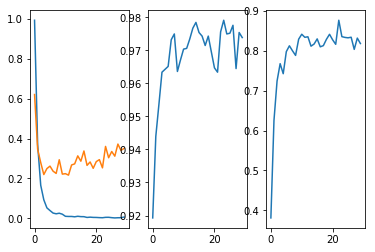

accuracy of folds: [0.9910597470562582, 0.9906449044585988, 0.9798826487845766, 0.9785390012381345, 0.9755671902268761]
average accuracy: 0.9831386983528889
f1 of folds: [0.9428964651202241, 0.9151593535598465, 0.8993075499358272, 0.8228883780586927, 0.8762626844140069]
average f1: 0.8913028862177195
mu= 0.1
Fold 1:
Epoch: 0
Validation loss: 2.6629582941532135
Validation Accuracy: 0.0641081552551243
F1-Score: 0.020045358799410024

Epoch: 10
Train loss: 0.012486860606198509
Validation loss: 0.09715513524133712
Validation Accuracy: 0.984954208460532
F1-Score: 0.8941170395578328

Epoch: 20
Train loss: 0.0050740908520917095
Validation loss: 0.08622193030896597
Validation Accuracy: 0.9862625381596162
F1-Score: 0.9111674814220228

Epoch: 30
Train loss: 0.0017740317154675723
Validation loss: 0.0901428575580212
Validation Accuracy: 0.9871347579590056
F1-Score: 0.9185888262892024

The best result: 
Validation Accuracy: 0.989751417357174, F1-Score: 0.9453575186747281


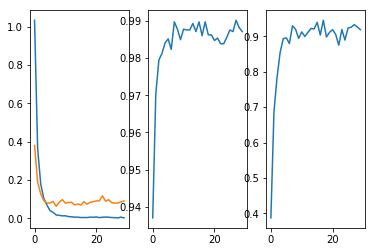

Fold 2:
Epoch: 0
Validation loss: 2.6016285717487335
Validation Accuracy: 0.07842356687898089
F1-Score: 0.020837675232690044

Epoch: 10
Train loss: 0.010752884641988203
Validation loss: 0.13023816095665097
Validation Accuracy: 0.98328025477707
F1-Score: 0.8588086640934603

Epoch: 20
Train loss: 0.00553589896686996
Validation loss: 0.12179597234353423
Validation Accuracy: 0.9864649681528662
F1-Score: 0.8794635961011825

Epoch: 30
Train loss: 0.0033621816449643425
Validation loss: 0.15640117996372283
Validation Accuracy: 0.9850716560509554
F1-Score: 0.8879469948195814

The best result: 
Validation Accuracy: 0.9850716560509554, F1-Score: 0.8879469948195814


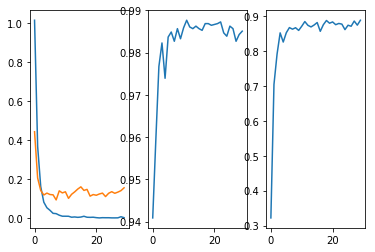

Fold 3:
Epoch: 0
Validation loss: 2.550409972667694
Validation Accuracy: 0.08528918692372171
F1-Score: 0.024403062696599316

Epoch: 10
Train loss: 0.011354296025820077
Validation loss: 0.1977519802749157
Validation Accuracy: 0.9803017602682313
F1-Score: 0.9001175030665409

Epoch: 20
Train loss: 0.002421710139606148
Validation loss: 0.19649877399206161
Validation Accuracy: 0.9784157585917854
F1-Score: 0.8909995339267754

Epoch: 30
Train loss: 0.01027798767221005
Validation loss: 0.25326735398266464
Validation Accuracy: 0.9794635373009221
F1-Score: 0.8409692622601644

The best result: 
Validation Accuracy: 0.9817686504610227, F1-Score: 0.9073116204437519


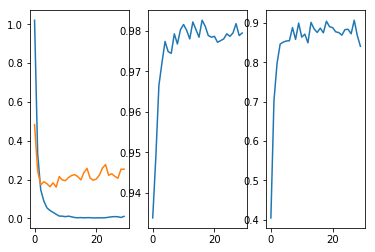

Fold 4:
Epoch: 0
Validation loss: 2.4904215335845947
Validation Accuracy: 0.21935617003714403
F1-Score: 0.03965265144496145

Epoch: 10
Train loss: 0.010967818674786637
Validation loss: 0.19262803811579943
Validation Accuracy: 0.9779199339661576
F1-Score: 0.8040189517709548

Epoch: 20
Train loss: 0.003583570270954321
Validation loss: 0.2634440502151847
Validation Accuracy: 0.9770945109368552
F1-Score: 0.8130058446454231

Epoch: 30
Train loss: 0.0029684924598162373
Validation loss: 0.19080221187323332
Validation Accuracy: 0.9775072224515065
F1-Score: 0.8021109505341306

The best result: 
Validation Accuracy: 0.9789517127527858, F1-Score: 0.8788851801733296


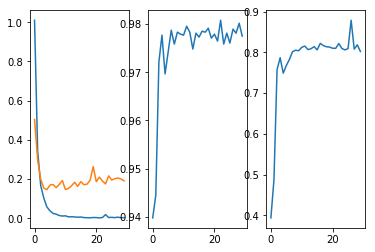

Fold 5:
Epoch: 0
Validation loss: 2.7015894055366516
Validation Accuracy: 0.07089877835951135
F1-Score: 0.017267078702713764

Epoch: 10
Train loss: 0.015244161826558411
Validation loss: 0.2082763679791242
Validation Accuracy: 0.9727312390924956
F1-Score: 0.8462869235586518

Epoch: 20
Train loss: 0.005321664110912631
Validation loss: 0.2440072053577751
Validation Accuracy: 0.9794938917975567
F1-Score: 0.8475088223538764

Epoch: 30
Train loss: 0.0037321177844811854
Validation loss: 0.22114836412947625
Validation Accuracy: 0.9794938917975567
F1-Score: 0.853920200722234

The best result: 
Validation Accuracy: 0.9725130890052356, F1-Score: 0.8563549819307249


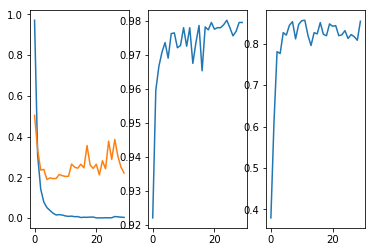

accuracy of folds: [0.989751417357174, 0.9850716560509554, 0.9817686504610227, 0.9789517127527858, 0.9725130890052356]
average accuracy: 0.9816113051254346
f1 of folds: [0.9453575186747281, 0.8879469948195814, 0.9073116204437519, 0.8788851801733296, 0.8563549819307249]
average f1: 0.8951712592084231
mu= 0.2
Fold 1:
Epoch: 0
Validation loss: 2.5154696702957153
Validation Accuracy: 0.25032708242477103
F1-Score: 0.040536354866855265

Epoch: 10
Train loss: 0.011234579235315323
Validation loss: 0.07017873400036478
Validation Accuracy: 0.9862625381596162
F1-Score: 0.8977730097011791

Epoch: 20
Train loss: 0.007297996311293294
Validation loss: 0.07295659937153687
Validation Accuracy: 0.986698648059311
F1-Score: 0.9119051428331498

Epoch: 30
Train loss: 0.003970678298113247
Validation loss: 0.0977289283018763
Validation Accuracy: 0.98430004361099
F1-Score: 0.8761185570309334

The best result: 
Validation Accuracy: 0.9880069777583951, F1-Score: 0.9191254353422528


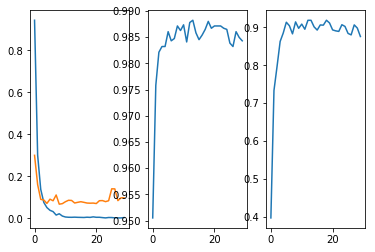

Fold 2:
Epoch: 0
Validation loss: 2.790119469165802
Validation Accuracy: 0.011146496815286623
F1-Score: 0.008562734155473406

Epoch: 10
Train loss: 0.014451193634886294
Validation loss: 0.11976828891783953
Validation Accuracy: 0.9842754777070064
F1-Score: 0.8635789910194345

Epoch: 20
Train loss: 0.0026692219330774
Validation loss: 0.11146605235990137
Validation Accuracy: 0.9834792993630573
F1-Score: 0.861293330296893

Epoch: 30
Train loss: 0.002965032635256648
Validation loss: 0.15318039624253288
Validation Accuracy: 0.9850716560509554
F1-Score: 0.8605970218029104

The best result: 
Validation Accuracy: 0.982484076433121, F1-Score: 0.8821690081254043


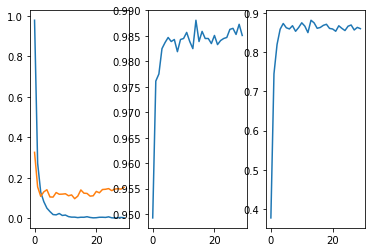

Fold 3:
Epoch: 0
Validation loss: 2.649258255958557
Validation Accuracy: 0.05762782900251467
F1-Score: 0.014583620737655833

Epoch: 10
Train loss: 0.008133053213047485
Validation loss: 0.17998079024255276
Validation Accuracy: 0.9798826487845766
F1-Score: 0.8651753945989664

Epoch: 20
Train loss: 0.001961304229917005
Validation loss: 0.22019804827868938
Validation Accuracy: 0.9809304274937133
F1-Score: 0.8914136604931114

Epoch: 30
Train loss: 0.0017916128611735378
Validation loss: 0.21135546825826168
Validation Accuracy: 0.9819782062028499
F1-Score: 0.8921092192037207

The best result: 
Validation Accuracy: 0.9821877619446773, F1-Score: 0.9086745964563497


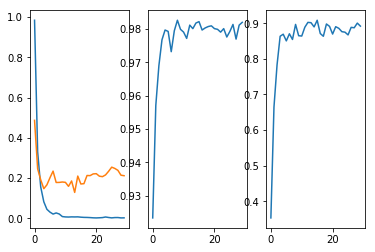

Fold 4:
Epoch: 0
Validation loss: 2.75115305185318
Validation Accuracy: 0.020841931489888568
F1-Score: 0.023158715821470593

Epoch: 10
Train loss: 0.010271809878759086
Validation loss: 0.1435258467681706
Validation Accuracy: 0.9808089145687164
F1-Score: 0.8020476879137222

Epoch: 20
Train loss: 0.0018878288780494283
Validation loss: 0.17903572088107467
Validation Accuracy: 0.9791580685101114
F1-Score: 0.800998950036788

Epoch: 30
Train loss: 0.009797173280579349
Validation loss: 0.23249195935204625
Validation Accuracy: 0.9773008666941808
F1-Score: 0.7881615408479049

The best result: 
Validation Accuracy: 0.9791580685101114, F1-Score: 0.819190744339209


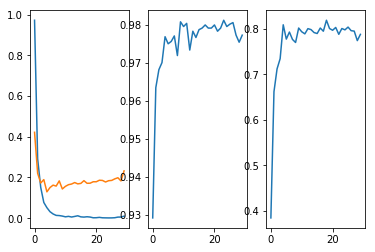

Fold 5:
Epoch: 0
Validation loss: 2.832208216190338
Validation Accuracy: 0.004799301919720768
F1-Score: 0.004728888027845273

Epoch: 10
Train loss: 0.012348849349655211
Validation loss: 0.24355003191158175
Validation Accuracy: 0.9714223385689355
F1-Score: 0.8085496624297561

Epoch: 20
Train loss: 0.0017185291333589702
Validation loss: 0.2949074413627386
Validation Accuracy: 0.9760034904013961
F1-Score: 0.8011770195016671

Epoch: 30
Train loss: 0.0028808384338238585
Validation loss: 0.32983928360044956
Validation Accuracy: 0.974476439790576
F1-Score: 0.8092403578021111

The best result: 
Validation Accuracy: 0.9712041884816754, F1-Score: 0.8617330303525491


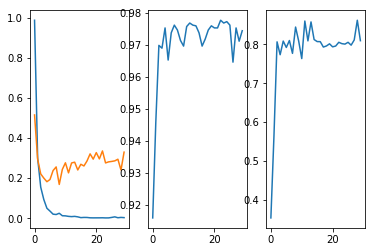

accuracy of folds: [0.9880069777583951, 0.982484076433121, 0.9821877619446773, 0.9791580685101114, 0.9712041884816754]
average accuracy: 0.980608214625596
f1 of folds: [0.9191254353422528, 0.8821690081254043, 0.9086745964563497, 0.819190744339209, 0.8617330303525491]
average f1: 0.878178562923153
mu= 0.3
Fold 1:
Epoch: 0
Validation loss: 2.616051286458969
Validation Accuracy: 0.08591365023986045
F1-Score: 0.02182485125046508

Epoch: 10
Train loss: 0.01171610812501361
Validation loss: 0.06643395414721454
Validation Accuracy: 0.9847361535106847
F1-Score: 0.8954620615403275

Epoch: 20
Train loss: 0.003921290795551613
Validation loss: 0.07065038143628044
Validation Accuracy: 0.9875708678587004
F1-Score: 0.934556993824333

Epoch: 30
Train loss: 0.0022915757862695804
Validation loss: 0.07214366493280977
Validation Accuracy: 0.987352812908853
F1-Score: 0.9168653763558515

The best result: 
Validation Accuracy: 0.9858264282599215, F1-Score: 0.9383571848612845


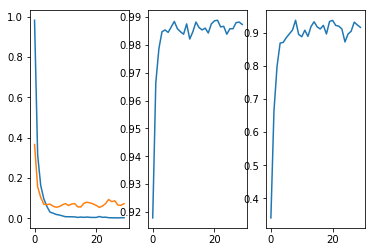

Fold 2:
Epoch: 0
Validation loss: 2.608361303806305
Validation Accuracy: 0.18371815286624205
F1-Score: 0.028942458651620043

Epoch: 10
Train loss: 0.010140522984632602
Validation loss: 0.1093829208984971
Validation Accuracy: 0.982484076433121
F1-Score: 0.870226339253664

Epoch: 20
Train loss: 0.0036217603910093507
Validation loss: 0.12690745294094086
Validation Accuracy: 0.98546974522293
F1-Score: 0.8705312627809147

Epoch: 30
Train loss: 0.0033934578891300286
Validation loss: 0.1437442687456496
Validation Accuracy: 0.9834792993630573
F1-Score: 0.8590333335672903

The best result: 
Validation Accuracy: 0.9852707006369427, F1-Score: 0.8987134087699162


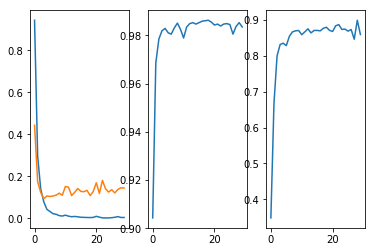

Fold 3:
Epoch: 0
Validation loss: 2.6805655658245087
Validation Accuracy: 0.023260687342833195
F1-Score: 0.020207043888373993

Epoch: 10
Train loss: 0.006746725466412803
Validation loss: 0.1687279548496008
Validation Accuracy: 0.9790444258172674
F1-Score: 0.8762844011863652

Epoch: 20
Train loss: 0.003360688630103444
Validation loss: 0.26267836708575487
Validation Accuracy: 0.980092204526404
F1-Score: 0.8604879891085015

Epoch: 30
Train loss: 0.004491398947235817
Validation loss: 0.241778876632452
Validation Accuracy: 0.9790444258172674
F1-Score: 0.8558692905253917

The best result: 
Validation Accuracy: 0.982606873428332, F1-Score: 0.8835331772962126


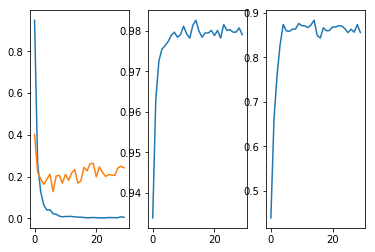

Fold 4:
Epoch: 0
Validation loss: 2.791139781475067
Validation Accuracy: 0.015270326042096575
F1-Score: 0.01747043961431285

Epoch: 10
Train loss: 0.007190105276337514
Validation loss: 0.16906218137592077
Validation Accuracy: 0.9768881551795295
F1-Score: 0.8096205181227771

Epoch: 20
Train loss: 0.004532031456862266
Validation loss: 0.18860247917473316
Validation Accuracy: 0.9764754436648783
F1-Score: 0.7890280981839446

Epoch: 30
Train loss: 0.005560954324513053
Validation loss: 0.22086127242073417
Validation Accuracy: 0.9752373091209244
F1-Score: 0.7829622684659454

The best result: 
Validation Accuracy: 0.9806025588113908, F1-Score: 0.8295097558265723


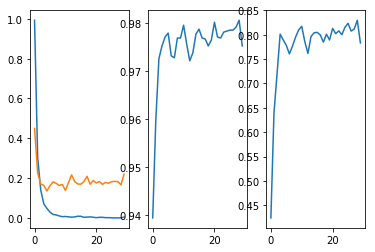

Fold 5:
Epoch: 0
Validation loss: 2.786957859992981
Validation Accuracy: 0.012434554973821989
F1-Score: 0.004763688536085606

Epoch: 10
Train loss: 0.010497081729893883
Validation loss: 0.21642481815069914
Validation Accuracy: 0.9712041884816754
F1-Score: 0.8235952117812045

Epoch: 20
Train loss: 0.0038316180425075194
Validation loss: 0.21773067116737366
Validation Accuracy: 0.981675392670157
F1-Score: 0.8380063289789775

Epoch: 30
Train loss: 0.006738033897515076
Validation loss: 0.20303744543343782
Validation Accuracy: 0.9794938917975567
F1-Score: 0.8376230908423913

The best result: 
Validation Accuracy: 0.981675392670157, F1-Score: 0.8380063289789775


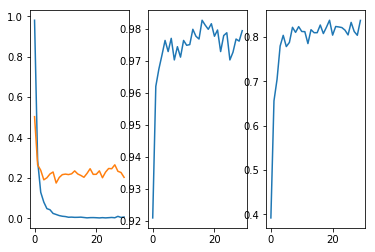

accuracy of folds: [0.9858264282599215, 0.9852707006369427, 0.982606873428332, 0.9806025588113908, 0.981675392670157]
average accuracy: 0.9831963907613488
f1 of folds: [0.9383571848612845, 0.8987134087699162, 0.8835331772962126, 0.8295097558265723, 0.8380063289789775]
average f1: 0.8776239711465926
mu= 0.4
Fold 1:
Epoch: 0
Validation loss: 2.7810926139354706
Validation Accuracy: 0.030309638028783253
F1-Score: 0.020720366771731853

Epoch: 10
Train loss: 0.011379608449836572
Validation loss: 0.06681084902083967
Validation Accuracy: 0.9875708678587004
F1-Score: 0.8949033611056376

Epoch: 20
Train loss: 0.005797862463320295
Validation loss: 0.06835257003876904
Validation Accuracy: 0.9895333624073267
F1-Score: 0.9107935787726238

Epoch: 30
Train loss: 0.0016685727867297828
Validation loss: 0.07850854119351425
Validation Accuracy: 0.9899694723070214
F1-Score: 0.9310174119127712

The best result: 
Validation Accuracy: 0.9895333624073267, F1-Score: 0.9315595275389588


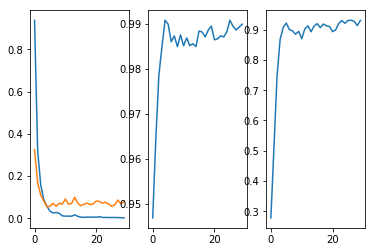

Fold 2:
Epoch: 0
Validation loss: 2.697025805711746
Validation Accuracy: 0.022093949044585986
F1-Score: 0.010906685637784694

Epoch: 10
Train loss: 0.016379122354555874
Validation loss: 0.11721180472522974
Validation Accuracy: 0.9856687898089171
F1-Score: 0.8796396270702563

Epoch: 20
Train loss: 0.0027288843547770133
Validation loss: 0.11564092249318492
Validation Accuracy: 0.9860668789808917
F1-Score: 0.8562584360768449

Epoch: 30
Train loss: 0.0028838698480588695
Validation loss: 0.11691738106310368
Validation Accuracy: 0.9866640127388535
F1-Score: 0.8762703838186806

The best result: 
Validation Accuracy: 0.9864649681528662, F1-Score: 0.89403757884493


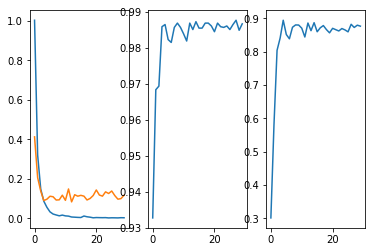

Fold 3:
Epoch: 0
Validation loss: 2.6188359558582306
Validation Accuracy: 0.04798826487845767
F1-Score: 0.019762960511793833

Epoch: 10
Train loss: 0.007897753687575459
Validation loss: 0.20386092364788055
Validation Accuracy: 0.9779966471081307
F1-Score: 0.857818005259464

Epoch: 20
Train loss: 0.0028758339312238
Validation loss: 0.19588179886341095
Validation Accuracy: 0.9809304274937133
F1-Score: 0.865901235239219

Epoch: 30
Train loss: 0.0011622722677808875
Validation loss: 0.24186057690531015
Validation Accuracy: 0.9815590947191953
F1-Score: 0.8971356887623627

The best result: 
Validation Accuracy: 0.9809304274937133, F1-Score: 0.8978042209183668


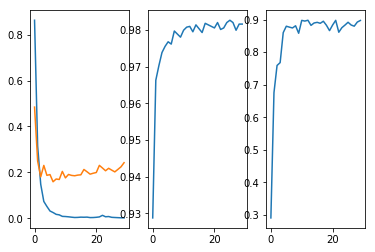

Fold 4:
Epoch: 0
Validation loss: 2.8573386669158936
Validation Accuracy: 0.01361947998349154
F1-Score: 0.019146431875914284

Epoch: 10
Train loss: 0.011330572275134424
Validation loss: 0.1521611069329083
Validation Accuracy: 0.9768881551795295
F1-Score: 0.8021603757753387

Epoch: 20
Train loss: 0.0023846579618596784
Validation loss: 0.18392634997144341
Validation Accuracy: 0.9775072224515065
F1-Score: 0.8071740367557516

Epoch: 30
Train loss: 0.0038114552706247197
Validation loss: 0.1830876157619059
Validation Accuracy: 0.979983491539414
F1-Score: 0.8057729369930645

The best result: 
Validation Accuracy: 0.9758563763929013, F1-Score: 0.8589138925701226


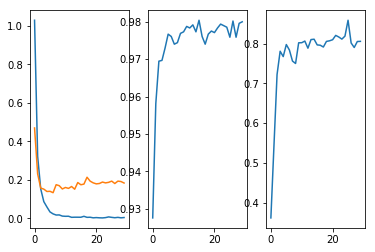

Fold 5:
Epoch: 0
Validation loss: 2.5223193168640137
Validation Accuracy: 0.2547993019197208
F1-Score: 0.06383258622370554

Epoch: 10
Train loss: 0.010147534186641376
Validation loss: 0.17172669619321823
Validation Accuracy: 0.9729493891797557
F1-Score: 0.796867617614168

Epoch: 20
Train loss: 0.004586707036166141
Validation loss: 0.21237611956894398
Validation Accuracy: 0.9790575916230366
F1-Score: 0.8166595535493483

Epoch: 30
Train loss: 0.004320573386697409
Validation loss: 0.28630675189197063
Validation Accuracy: 0.9766579406631762
F1-Score: 0.8212563017409521

The best result: 
Validation Accuracy: 0.9722949389179756, F1-Score: 0.8486675647809848


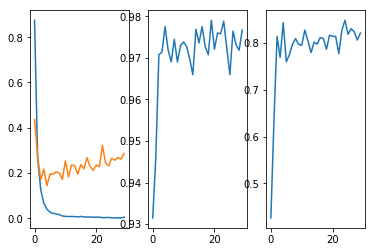

accuracy of folds: [0.9895333624073267, 0.9864649681528662, 0.9809304274937133, 0.9758563763929013, 0.9722949389179756]
average accuracy: 0.9810160146729565
f1 of folds: [0.9315595275389588, 0.89403757884493, 0.8978042209183668, 0.8589138925701226, 0.8486675647809848]
average f1: 0.8861965569306726
mu= 0.5
Fold 1:
Epoch: 0
Validation loss: 2.6339949667453766
Validation Accuracy: 0.07130396860008723
F1-Score: 0.01619184171532828

Epoch: 10
Train loss: 0.015392591912920276
Validation loss: 0.07704411795566557
Validation Accuracy: 0.9832097688617532
F1-Score: 0.8909508306074027

Epoch: 20
Train loss: 0.003810219909064472
Validation loss: 0.06238343456243456
Validation Accuracy: 0.9871347579590056
F1-Score: 0.8997116455476727

Epoch: 30
Train loss: 0.003245719889916169
Validation loss: 0.08493942812674504
Validation Accuracy: 0.9862625381596162
F1-Score: 0.8727909720066508

The best result: 
Validation Accuracy: 0.9829917139119058, F1-Score: 0.9318679795097353


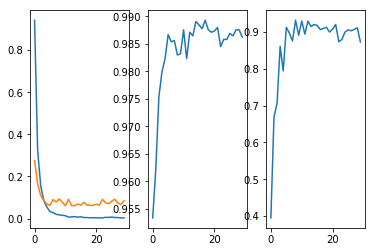

Fold 2:
Epoch: 0
Validation loss: 2.732710748910904
Validation Accuracy: 0.0384156050955414
F1-Score: 0.009636402881101572

Epoch: 10
Train loss: 0.01118227222468704
Validation loss: 0.1308978982269764
Validation Accuracy: 0.9856687898089171
F1-Score: 0.8627935063371558

Epoch: 20
Train loss: 0.004207521880744025
Validation loss: 0.10362017247825861
Validation Accuracy: 0.98328025477707
F1-Score: 0.8705586920069089

Epoch: 30
Train loss: 0.003138171992031857
Validation loss: 0.11945294018369168
Validation Accuracy: 0.9866640127388535
F1-Score: 0.8828037775372433

The best result: 
Validation Accuracy: 0.9868630573248408, F1-Score: 0.9113624805793447


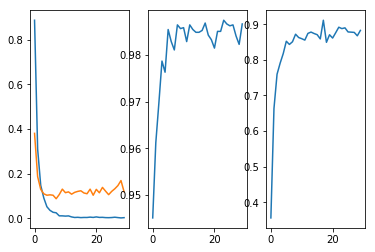

Fold 3:
Epoch: 0
Validation loss: 2.750123620033264
Validation Accuracy: 0.019279128248113998
F1-Score: 0.011400763058432187

Epoch: 10
Train loss: 0.006112527688189099
Validation loss: 0.18513773940503597
Validation Accuracy: 0.9809304274937133
F1-Score: 0.8837660621607826

Epoch: 20
Train loss: 0.004188915066576252
Validation loss: 0.19215674232691526
Validation Accuracy: 0.9817686504610227
F1-Score: 0.8850645608702549

Epoch: 30
Train loss: 0.003946241454104893
Validation loss: 0.20398331061005592
Validation Accuracy: 0.980092204526404
F1-Score: 0.883540778253509

The best result: 
Validation Accuracy: 0.9819782062028499, F1-Score: 0.8930452709371811


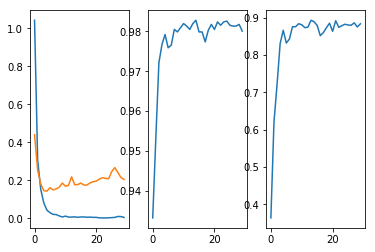

Fold 4:
Epoch: 0
Validation loss: 2.4877956807613373
Validation Accuracy: 0.2717705323978539
F1-Score: 0.047370497445480976

Epoch: 10
Train loss: 0.008933582956281801
Validation loss: 0.1466776868328452
Validation Accuracy: 0.9793644242674371
F1-Score: 0.8149375319312077

Epoch: 20
Train loss: 0.0038800576061476023
Validation loss: 0.214381352532655
Validation Accuracy: 0.9729673957903425
F1-Score: 0.752694559676457

Epoch: 30
Train loss: 0.002955506218131632
Validation loss: 0.1969486940652132
Validation Accuracy: 0.9750309533635988
F1-Score: 0.8099440769309477

The best result: 
Validation Accuracy: 0.9770945109368552, F1-Score: 0.8655946637450506


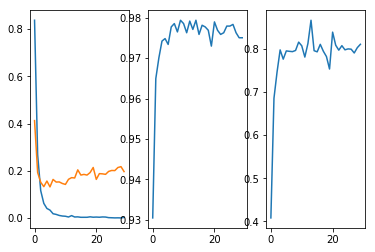

Fold 5:
Epoch: 0
Validation loss: 2.782005488872528
Validation Accuracy: 0.005017452006980803
F1-Score: 0.011275991768504289

Epoch: 10
Train loss: 0.014517677583110828
Validation loss: 0.2318186778575182
Validation Accuracy: 0.9757853403141361
F1-Score: 0.869257256907807

Epoch: 20
Train loss: 0.01294106530646483
Validation loss: 0.21848236955702305
Validation Accuracy: 0.9760034904013961
F1-Score: 0.8015805971069792

Epoch: 30
Train loss: 0.0017109935181603456
Validation loss: 0.23538310965523124
Validation Accuracy: 0.9764397905759162
F1-Score: 0.7925673840014386

The best result: 
Validation Accuracy: 0.974476439790576, F1-Score: 0.877534490266371


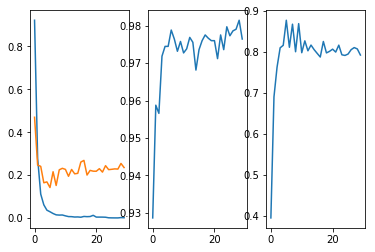

accuracy of folds: [0.9829917139119058, 0.9868630573248408, 0.9819782062028499, 0.9770945109368552, 0.974476439790576]
average accuracy: 0.9806807856334055
f1 of folds: [0.9318679795097353, 0.9113624805793447, 0.8930452709371811, 0.8655946637450506, 0.877534490266371]
average f1: 0.8958809770075365
mu= 0.6
Fold 1:
Epoch: 0
Validation loss: 2.8277570009231567
Validation Accuracy: 0.009594417793283908
F1-Score: 0.009527560924534615

Epoch: 10
Train loss: 0.009935980606436108
Validation loss: 0.06810551916714758
Validation Accuracy: 0.9880069777583951
F1-Score: 0.9321763964080715

Epoch: 20
Train loss: 0.003526250449552511
Validation loss: 0.06957896879248437
Validation Accuracy: 0.9877889228085478
F1-Score: 0.9249443895006979

Epoch: 30
Train loss: 0.00404748809717906
Validation loss: 0.08389546869329934
Validation Accuracy: 0.9869167030091583
F1-Score: 0.921409315863046

The best result: 
Validation Accuracy: 0.9895333624073267, F1-Score: 0.9427618126861762


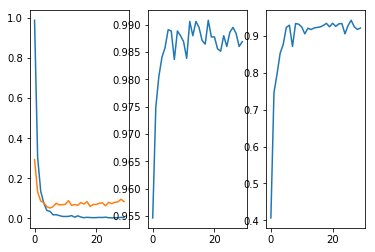

Fold 2:
Epoch: 0
Validation loss: 2.619177222251892
Validation Accuracy: 0.07822452229299363
F1-Score: 0.020879354733054134

Epoch: 10
Train loss: 0.012697256829900047
Validation loss: 0.10233668141881935
Validation Accuracy: 0.9878582802547771
F1-Score: 0.865181012520927

Epoch: 20
Train loss: 0.0021766337954128782
Validation loss: 0.13024973939172924
Validation Accuracy: 0.9868630573248408
F1-Score: 0.877479922164298

Epoch: 30
Train loss: 0.00644981565225559
Validation loss: 0.13125484995543957
Validation Accuracy: 0.9876592356687898
F1-Score: 0.8634685756545057

The best result: 
Validation Accuracy: 0.9878582802547771, F1-Score: 0.8900456566592285


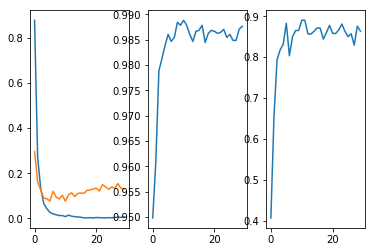

Fold 3:
Epoch: 0
Validation loss: 2.6267417669296265
Validation Accuracy: 0.03499580888516345
F1-Score: 0.03306791297288101

Epoch: 10
Train loss: 0.009745440857174496
Validation loss: 0.16440842486917973
Validation Accuracy: 0.9794635373009221
F1-Score: 0.8736586566388626

Epoch: 20
Train loss: 0.003984259398809324
Validation loss: 0.1895894268527627
Validation Accuracy: 0.9779966471081307
F1-Score: 0.8465452945152208

Epoch: 30
Train loss: 0.0020546354620213
Validation loss: 0.2298994641751051
Validation Accuracy: 0.9798826487845766
F1-Score: 0.8585114580756118

The best result: 
Validation Accuracy: 0.9819782062028499, F1-Score: 0.8915176933868161


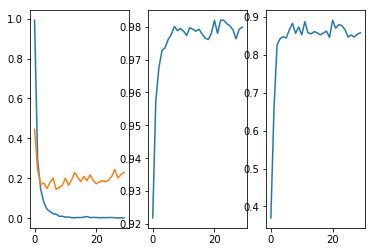

Fold 4:
Epoch: 0
Validation loss: 2.840968579053879
Validation Accuracy: 0.03033429632686752
F1-Score: 0.01853781998933357

Epoch: 10
Train loss: 0.011048908772257468
Validation loss: 0.17102101095952094
Validation Accuracy: 0.9806025588113908
F1-Score: 0.8006453105582464

Epoch: 20
Train loss: 0.001844419203310584
Validation loss: 0.1779521993594244
Validation Accuracy: 0.9752373091209244
F1-Score: 0.8025098197701114

Epoch: 30
Train loss: 0.004766830545850098
Validation loss: 0.18893871153704822
Validation Accuracy: 0.977713578208832
F1-Score: 0.8166517685922362

The best result: 
Validation Accuracy: 0.977713578208832, F1-Score: 0.8297139109463961


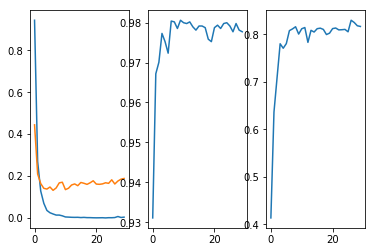

Fold 5:
Epoch: 0
Validation loss: 2.517903119325638
Validation Accuracy: 0.07853403141361257
F1-Score: 0.027198270150257314

Epoch: 10
Train loss: 0.01039287366050606
Validation loss: 0.19240602757781744
Validation Accuracy: 0.9755671902268761
F1-Score: 0.8130836752150775

Epoch: 20
Train loss: 0.0042424592073075475
Validation loss: 0.22468283213675022
Validation Accuracy: 0.9768760907504364
F1-Score: 0.8109880230874459

Epoch: 30
Train loss: 0.0022600125385603556
Validation loss: 0.19352720957249403
Validation Accuracy: 0.9738219895287958
F1-Score: 0.865305207614981

The best result: 
Validation Accuracy: 0.9738219895287958, F1-Score: 0.865305207614981


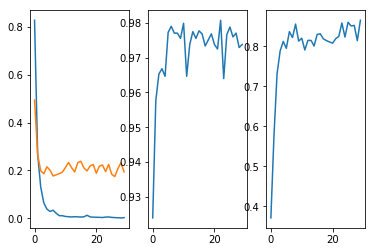

accuracy of folds: [0.9895333624073267, 0.9878582802547771, 0.9819782062028499, 0.977713578208832, 0.9738219895287958]
average accuracy: 0.9821810833205162
f1 of folds: [0.9427618126861762, 0.8900456566592285, 0.8915176933868161, 0.8297139109463961, 0.865305207614981]
average f1: 0.8838688562587196
mu= 0.7
Fold 1:
Epoch: 0
Validation loss: 2.6020484566688538
Validation Accuracy: 0.04884430876580898
F1-Score: 0.013335499695909529

Epoch: 10
Train loss: 0.008895797608420252
Validation loss: 0.0750070681096986
Validation Accuracy: 0.9856083733100741
F1-Score: 0.8981683199540684

Epoch: 20
Train loss: 0.003061387660757949
Validation loss: 0.06627055942044535
Validation Accuracy: 0.9884430876580899
F1-Score: 0.9298915317593293

Epoch: 30
Train loss: 0.0059303322166670116
Validation loss: 0.07436909749230836
Validation Accuracy: 0.9858264282599215
F1-Score: 0.8950526489218433

The best result: 
Validation Accuracy: 0.9888791975577845, F1-Score: 0.9381354536805493


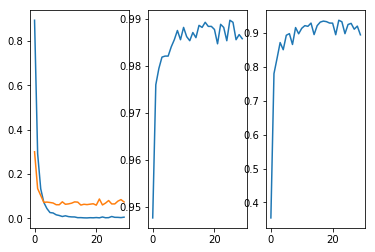

Fold 2:
Epoch: 0
Validation loss: 2.6734399497509003
Validation Accuracy: 0.03662420382165605
F1-Score: 0.008230435003000556

Epoch: 10
Train loss: 0.015886540181236343
Validation loss: 0.10564705933211371
Validation Accuracy: 0.9842754777070064
F1-Score: 0.8817518032317905

Epoch: 20
Train loss: 0.0036705649302651486
Validation loss: 0.09602376515977085
Validation Accuracy: 0.9874601910828026
F1-Score: 0.8865233349376267

Epoch: 30
Train loss: 0.0035332154841550317
Validation loss: 0.13357159867882729
Validation Accuracy: 0.9858678343949044
F1-Score: 0.8628047239735022

The best result: 
Validation Accuracy: 0.9874601910828026, F1-Score: 0.8893299815838772


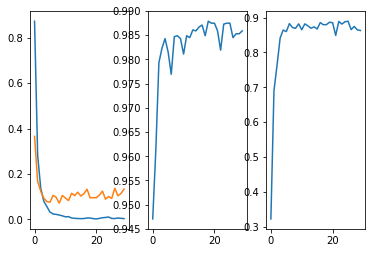

Fold 3:
Epoch: 0
Validation loss: 2.818698465824127
Validation Accuracy: 0.01068734283319363
F1-Score: 0.004956646054519275

Epoch: 10
Train loss: 0.012200223235413431
Validation loss: 0.15712546836584806
Validation Accuracy: 0.9769488683989941
F1-Score: 0.8637266520227136

Epoch: 20
Train loss: 0.003153334061304728
Validation loss: 0.16390697471797466
Validation Accuracy: 0.9794635373009221
F1-Score: 0.8726715282567363

Epoch: 30
Train loss: 0.002733664575498551
Validation loss: 0.20406220853328705
Validation Accuracy: 0.9794635373009221
F1-Score: 0.8618736694694407

The best result: 
Validation Accuracy: 0.9786253143336128, F1-Score: 0.8818444555955505


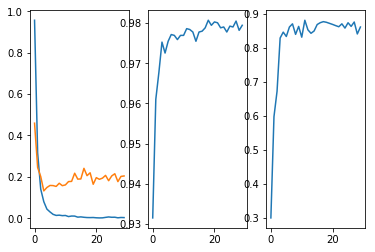

Fold 4:
Epoch: 0
Validation loss: 2.633697360754013
Validation Accuracy: 0.06479570780024763
F1-Score: 0.023356013594419977

Epoch: 10
Train loss: 0.006895056557065497
Validation loss: 0.14191341283731163
Validation Accuracy: 0.9812216260833677
F1-Score: 0.814306608167771

Epoch: 20
Train loss: 0.0018544160469900818
Validation loss: 0.15233771922066808
Validation Accuracy: 0.9781262897234833
F1-Score: 0.8270685756769078

Epoch: 30
Train loss: 0.006028795541108896
Validation loss: 0.15127591136842966
Validation Accuracy: 0.9808089145687164
F1-Score: 0.8184304322796213

The best result: 
Validation Accuracy: 0.9789517127527858, F1-Score: 0.8764917072598847


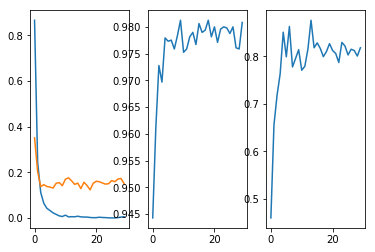

Fold 5:
Epoch: 0
Validation loss: 2.6435996890068054
Validation Accuracy: 0.051919720767888304
F1-Score: 0.018002275180019373

Epoch: 10
Train loss: 0.009441264986526221
Validation loss: 0.17546302918344736
Validation Accuracy: 0.9753490401396161
F1-Score: 0.8675828213447884

Epoch: 20
Train loss: 0.0027145964520362514
Validation loss: 0.2762490650638938
Validation Accuracy: 0.9720767888307156
F1-Score: 0.7722495955532699

Epoch: 30
Train loss: 0.0013149006719080111
Validation loss: 0.2422690885141492
Validation Accuracy: 0.9760034904013961
F1-Score: 0.8114322167446908

The best result: 
Validation Accuracy: 0.9718586387434555, F1-Score: 0.8681976910608932


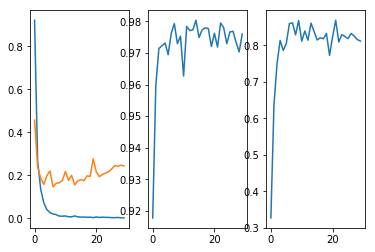

accuracy of folds: [0.9888791975577845, 0.9874601910828026, 0.9786253143336128, 0.9789517127527858, 0.9718586387434555]
average accuracy: 0.9811550108940883
f1 of folds: [0.9381354536805493, 0.8893299815838772, 0.8818444555955505, 0.8764917072598847, 0.8681976910608932]
average f1: 0.8907998578361509
mu= 0.8
Fold 1:
Epoch: 0
Validation loss: 2.447821170091629
Validation Accuracy: 0.4485390318360227
F1-Score: 0.05484105189427894

Epoch: 10
Train loss: 0.009138680765560517
Validation loss: 0.06532791070640087
Validation Accuracy: 0.9875708678587004
F1-Score: 0.9131278417749512

Epoch: 20
Train loss: 0.004270510513257856
Validation loss: 0.0820911711853114
Validation Accuracy: 0.9851722634103794
F1-Score: 0.9074696097513516

Epoch: 30
Train loss: 0.0011559098270178462
Validation loss: 0.06773809289916244
Validation Accuracy: 0.9893153074574793
F1-Score: 0.9363482551105758

The best result: 
Validation Accuracy: 0.9893153074574793, F1-Score: 0.9363482551105758


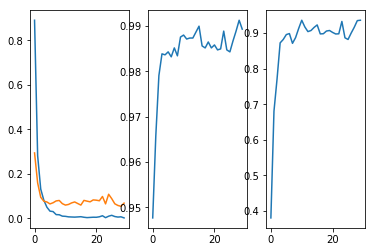

Fold 2:
Epoch: 0
Validation loss: 2.6178509294986725
Validation Accuracy: 0.08240445859872611
F1-Score: 0.02080005874723844

Epoch: 10
Train loss: 0.012715159845538438
Validation loss: 0.08835146320052445
Validation Accuracy: 0.9856687898089171
F1-Score: 0.8697086911835902

Epoch: 20
Train loss: 0.006273036312389498
Validation loss: 0.1438220172713045
Validation Accuracy: 0.9850716560509554
F1-Score: 0.8673270415332067

Epoch: 30
Train loss: 0.002011423764633946
Validation loss: 0.1138612285576528
Validation Accuracy: 0.9864649681528662
F1-Score: 0.8811931940584389

The best result: 
Validation Accuracy: 0.9838773885350318, F1-Score: 0.9257337138342869


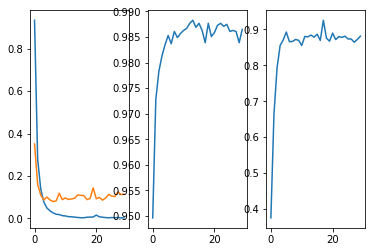

Fold 3:
Epoch: 0
Validation loss: 2.8515792191028595
Validation Accuracy: 0.014249790444258172
F1-Score: 0.016838453475068495

Epoch: 10
Train loss: 0.010920921247452498
Validation loss: 0.18407321255654097
Validation Accuracy: 0.9798826487845766
F1-Score: 0.8746375823549551

Epoch: 20
Train loss: 0.002700042194919661
Validation loss: 0.1849190816283226
Validation Accuracy: 0.9805113160100587
F1-Score: 0.8862268181961467

Epoch: 30
Train loss: 0.0033490935165900737
Validation loss: 0.20124730560928583
Validation Accuracy: 0.9805113160100587
F1-Score: 0.8744432862856293

The best result: 
Validation Accuracy: 0.9828164291701592, F1-Score: 0.9097696351220439


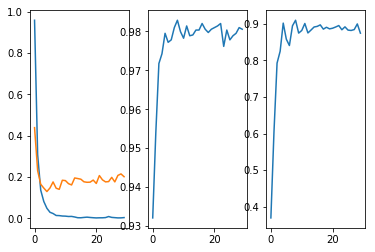

Fold 4:
Epoch: 0
Validation loss: 2.4981389939785004
Validation Accuracy: 0.310152703260421
F1-Score: 0.04275696779148646

Epoch: 10
Train loss: 0.010195134622820963
Validation loss: 0.1529462542384863
Validation Accuracy: 0.9779199339661576
F1-Score: 0.7667928250601891

Epoch: 20
Train loss: 0.009660743681403497
Validation loss: 0.13912265188992023
Validation Accuracy: 0.9795707800247627
F1-Score: 0.812195045795127

Epoch: 30
Train loss: 0.0026400000885284194
Validation loss: 0.16080161463469267
Validation Accuracy: 0.9791580685101114
F1-Score: 0.8024626465463025

The best result: 
Validation Accuracy: 0.9793644242674371, F1-Score: 0.8799865551122577


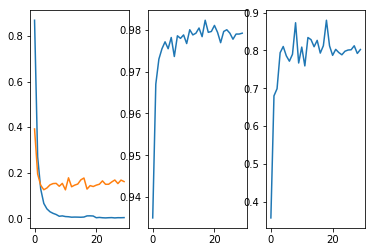

Fold 5:
Epoch: 0
Validation loss: 2.7403087615966797
Validation Accuracy: 0.0743891797556719
F1-Score: 0.021167077960058574

Epoch: 10
Train loss: 0.006475050052783141
Validation loss: 0.20066707022488117
Validation Accuracy: 0.9775305410122164
F1-Score: 0.8217229734533006

Epoch: 20
Train loss: 0.002759932909005632
Validation loss: 0.20582666341215372
Validation Accuracy: 0.9768760907504364
F1-Score: 0.82463247624295

Epoch: 30
Train loss: 0.005187200161162764
Validation loss: 0.2901555560529232
Validation Accuracy: 0.9762216404886562
F1-Score: 0.7867983923963077

The best result: 
Validation Accuracy: 0.9742582897033158, F1-Score: 0.8604089989778227


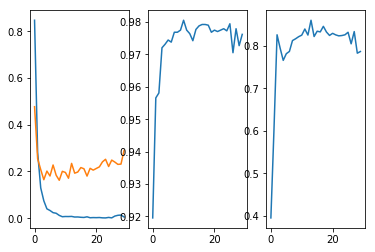

accuracy of folds: [0.9893153074574793, 0.9838773885350318, 0.9828164291701592, 0.9793644242674371, 0.9742582897033158]
average accuracy: 0.9819263678266846
f1 of folds: [0.9363482551105758, 0.9257337138342869, 0.9097696351220439, 0.8799865551122577, 0.8604089989778227]
average f1: 0.9024494316313973
mu= 0.9
Fold 1:
Epoch: 0
Validation loss: 2.631579339504242
Validation Accuracy: 0.04491931966855647
F1-Score: 0.027885964784808554

Epoch: 10
Train loss: 0.009289342459912102
Validation loss: 0.08855355944979237
Validation Accuracy: 0.9856083733100741
F1-Score: 0.9021452127802942

Epoch: 20
Train loss: 0.004827382562992474
Validation loss: 0.07423617129279592
Validation Accuracy: 0.9869167030091583
F1-Score: 0.8920397763077921

Epoch: 30
Train loss: 0.005306810756640819
Validation loss: 0.07105011809471762
Validation Accuracy: 0.9877889228085478
F1-Score: 0.9064607167332739

The best result: 
Validation Accuracy: 0.9908416921064108, F1-Score: 0.9337121383450742


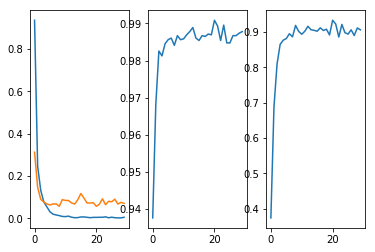

Fold 2:
Epoch: 0
Validation loss: 2.505404531955719
Validation Accuracy: 0.34653662420382164
F1-Score: 0.06424618974231112

Epoch: 10
Train loss: 0.01108340941524754
Validation loss: 0.08944633114151657
Validation Accuracy: 0.9874601910828026
F1-Score: 0.8752145270628765

Epoch: 20
Train loss: 0.00692840144620277
Validation loss: 0.1067319312132895
Validation Accuracy: 0.9858678343949044
F1-Score: 0.8675872199362884

Epoch: 30
Train loss: 0.003389581385999918
Validation loss: 0.1144640282727778
Validation Accuracy: 0.9876592356687898
F1-Score: 0.885099613939117

The best result: 
Validation Accuracy: 0.9868630573248408, F1-Score: 0.9021403676935693


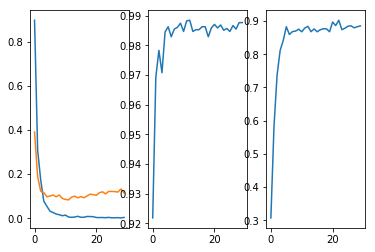

Fold 3:
Epoch: 0
Validation loss: 2.553602010011673
Validation Accuracy: 0.2709555741827326
F1-Score: 0.03718134924754844

Epoch: 10
Train loss: 0.006734391059338426
Validation loss: 0.17501766048371792
Validation Accuracy: 0.9794635373009221
F1-Score: 0.8640909592289975

Epoch: 20
Train loss: 0.002582106681074947
Validation loss: 0.21619294956326485
Validation Accuracy: 0.9777870913663035
F1-Score: 0.8648533810464205

Epoch: 30
Train loss: 0.0056294117898990715
Validation loss: 0.21795125864446163
Validation Accuracy: 0.9738055322715843
F1-Score: 0.8395451035601021

The best result: 
Validation Accuracy: 0.9790444258172674, F1-Score: 0.8807099406517771


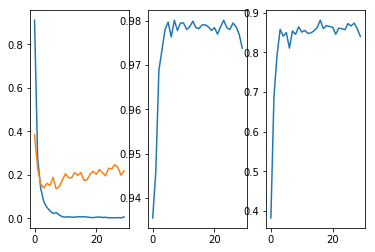

Fold 4:
Epoch: 0
Validation loss: 2.6970160603523254
Validation Accuracy: 0.008460586050350804
F1-Score: 0.0063228214170346474

Epoch: 10
Train loss: 0.011308518777756642
Validation loss: 0.125970549415797
Validation Accuracy: 0.977713578208832
F1-Score: 0.807992096079109

Epoch: 20
Train loss: 0.004137742333114147
Validation loss: 0.18493926525115967
Validation Accuracy: 0.9766817994222039
F1-Score: 0.8083854022972846

Epoch: 30
Train loss: 0.001546542244614102
Validation loss: 0.1630153306759894
Validation Accuracy: 0.9801898472967395
F1-Score: 0.8192816984211386

The best result: 
Validation Accuracy: 0.9828724721419727, F1-Score: 0.8392960268061209


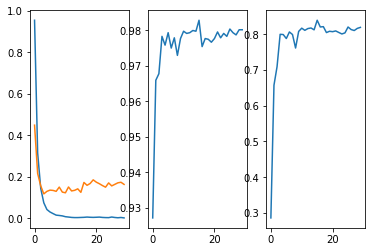

Fold 5:
Epoch: 0
Validation loss: 2.6116391122341156
Validation Accuracy: 0.1099476439790576
F1-Score: 0.029869759772701284

Epoch: 10
Train loss: 0.009196798084303737
Validation loss: 0.16324352752417326
Validation Accuracy: 0.9755671902268761
F1-Score: 0.8785551039765266

Epoch: 20
Train loss: 0.005929715457993249
Validation loss: 0.22946051601320505
Validation Accuracy: 0.9742582897033158
F1-Score: 0.7975400593509023

Epoch: 30
Train loss: 0.00489315915425929
Validation loss: 0.24721479322761297
Validation Accuracy: 0.9727312390924956
F1-Score: 0.7895844509182125

The best result: 
Validation Accuracy: 0.9755671902268761, F1-Score: 0.8785551039765266


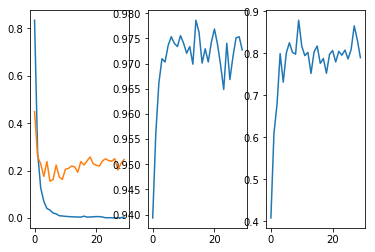

accuracy of folds: [0.9908416921064108, 0.9868630573248408, 0.9790444258172674, 0.9828724721419727, 0.9755671902268761]
average accuracy: 0.9830377675234736
f1 of folds: [0.9337121383450742, 0.9021403676935693, 0.8807099406517771, 0.8392960268061209, 0.8785551039765266]
average f1: 0.8868827154946135
mu= 1.0
Fold 1:
Epoch: 0
Validation loss: 2.7023236453533173
Validation Accuracy: 0.029437418229393806
F1-Score: 0.019090179164905012

Epoch: 10
Train loss: 0.014601876074448229
Validation loss: 0.07620138517086161
Validation Accuracy: 0.98430004361099
F1-Score: 0.8838565623053536

Epoch: 20
Train loss: 0.003663782802565644
Validation loss: 0.08330936528000166
Validation Accuracy: 0.9864805931094636
F1-Score: 0.9218062494632437

Epoch: 30
Train loss: 0.004697884555207565
Validation loss: 0.06596563145103573
Validation Accuracy: 0.9895333624073267
F1-Score: 0.9323430239176654

The best result: 
Validation Accuracy: 0.9895333624073267, F1-Score: 0.9323430239176654


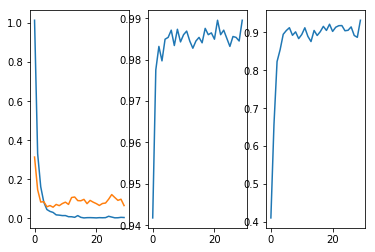

Fold 2:
Epoch: 0
Validation loss: 2.7928184270858765
Validation Accuracy: 0.018312101910828025
F1-Score: 0.019214322297834523

Epoch: 10
Train loss: 0.012222015326066564
Validation loss: 0.09988915210124105
Validation Accuracy: 0.9840764331210191
F1-Score: 0.8726370146226226

Epoch: 20
Train loss: 0.0035409208755784976
Validation loss: 0.11120965192094445
Validation Accuracy: 0.9858678343949044
F1-Score: 0.8688716281807383

Epoch: 30
Train loss: 0.004362831532489508
Validation loss: 0.10452209296636283
Validation Accuracy: 0.9852707006369427
F1-Score: 0.86289469337889

The best result: 
Validation Accuracy: 0.9860668789808917, F1-Score: 0.8881928286513674


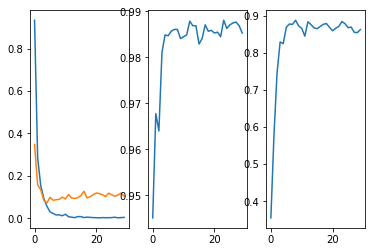

Fold 3:
Epoch: 0
Validation loss: 2.6368832886219025
Validation Accuracy: 0.09430008382229674
F1-Score: 0.02291188472179132

Epoch: 10
Train loss: 0.013400379979672531
Validation loss: 0.1505535626783967
Validation Accuracy: 0.9786253143336128
F1-Score: 0.8627158163130315

Epoch: 20
Train loss: 0.003144936007447541
Validation loss: 0.17745049204677343
Validation Accuracy: 0.9792539815590947
F1-Score: 0.8514954187219824

Epoch: 30
Train loss: 0.0021019187445441884
Validation loss: 0.1871606446802616
Validation Accuracy: 0.9819782062028499
F1-Score: 0.8851382939817304

The best result: 
Validation Accuracy: 0.9819782062028499, F1-Score: 0.8851382939817304


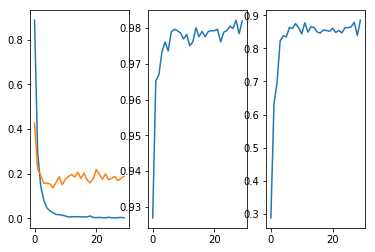

Fold 4:
Epoch: 0
Validation loss: 2.5539363622665405
Validation Accuracy: 0.12897234832851837
F1-Score: 0.02545399344278115

Epoch: 10
Train loss: 0.006864032110509773
Validation loss: 0.14479089621454477
Validation Accuracy: 0.9775072224515065
F1-Score: 0.787135397722208

Epoch: 20
Train loss: 0.0018309879659985503
Validation loss: 0.16552526084706187
Validation Accuracy: 0.9756500206355757
F1-Score: 0.7875369140714827

Epoch: 30
Train loss: 0.00253272454914016
Validation loss: 0.17541978368535638
Validation Accuracy: 0.9766817994222039
F1-Score: 0.814476292884872

The best result: 
Validation Accuracy: 0.9801898472967395, F1-Score: 0.8200916074953626


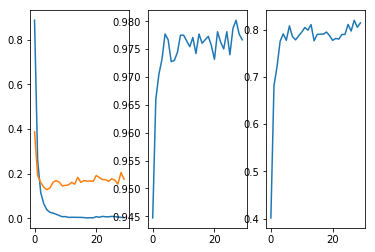

Fold 5:
Epoch: 0
Validation loss: 2.7005943953990936
Validation Accuracy: 0.023342059336823734
F1-Score: 0.013977323937317527

Epoch: 10
Train loss: 0.009999087767209858
Validation loss: 0.19798908289521933
Validation Accuracy: 0.9786212914485166
F1-Score: 0.7884781929925526

Epoch: 20
Train loss: 0.0035824119870085267
Validation loss: 0.2545137507840991
Validation Accuracy: 0.9781849912739965
F1-Score: 0.7970216186877799

Epoch: 30
Train loss: 0.001532277935378564
Validation loss: 0.22733126254752278
Validation Accuracy: 0.9790575916230366
F1-Score: 0.8205436446967618

The best result: 
Validation Accuracy: 0.9792757417102966, F1-Score: 0.8300131372642484


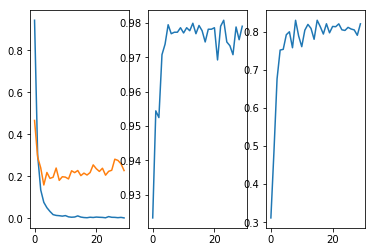

accuracy of folds: [0.9895333624073267, 0.9860668789808917, 0.9819782062028499, 0.9801898472967395, 0.9792757417102966]
average accuracy: 0.983408807319621
f1 of folds: [0.9323430239176654, 0.8881928286513674, 0.8851382939817304, 0.8200916074953626, 0.8300131372642484]
average f1: 0.8711557782620748


[(0, 0.9831386983528889, 0.8913028862177195),
 (1, 0.9816113051254346, 0.8951712592084231),
 (2, 0.980608214625596, 0.878178562923153),
 (3, 0.9831963907613488, 0.8776239711465926),
 (4, 0.9810160146729565, 0.8861965569306726),
 (5, 0.9806807856334055, 0.8958809770075365),
 (6, 0.9821810833205162, 0.8838688562587196),
 (7, 0.9811550108940883, 0.8907998578361509),
 (8, 0.9819263678266846, 0.9024494316313973),
 (9, 0.9830377675234736, 0.8868827154946135),
 (10, 0.983408807319621, 0.8711557782620748)]

<Figure size 432x288 with 0 Axes>

In [9]:
print('Cross Validation')
config['epochs']=30
acc_list = []
f1_list = []
for mu in range(11):
    print('mu=',mu/10)
    f = 1
    eval_accuracy_fold = [] 
    f1_fold = []
    model = None
    # enumerate splits
    for train_index, test_index in kfold.split(data_fold[0]):
        dataloader, count = myDataLoader(data_fold, train_index, test_index)

        weight = np.maximum(np.log((1+mu/10*(np.exp(1)-1))*max(count)/count),1)
        weight = torch.tensor(weight)
        print('Fold {}:'.format(f))
        del model
        model = BuildModel(config, weight)
        _, eval_accuracy, f1 = train(config, model, dataloader, if_plot=True, fold_id=f)
        eval_accuracy_fold.append(eval_accuracy)
        f1_fold.append(f1)
        f+=1
    print('accuracy of folds: {}'.format(eval_accuracy_fold))
    print('average accuracy: {}'.format(sum(eval_accuracy_fold)/fold_num))
    print('f1 of folds: {}'.format(f1_fold))
    print('average f1: {}'.format(sum(f1_fold)/fold_num))
    acc_list.append(sum(eval_accuracy_fold)/fold_num)
    f1_list.append(sum(f1_fold)/fold_num)
list(zip(range(11),acc_list,f1_list))

In [13]:
np.maximum(np.log((1+mu/10*(np.exp(1)-1))*max(count)/count),1)

array([1.        , 8.18442885, 6.67553217, 5.82275485, 8.06182653,
       6.65648398, 6.96321424, 5.65696259, 7.49128167, 5.64316927,
       7.11523045, 3.41632678, 7.20904921, 2.47919815])

In [2]:
import numpy as np
np.array([(1,2),(3,4)])

array([[1, 2],
       [3, 4]])

In [10]:
print('Cross Validation')
config['epochs']=30
acc_list = []
f1_list = []
for mu in range(0,11):
    print('mu=',mu/10)
    f = 1
    eval_accuracy_fold = [] 
    f1_fold = []
    model = None
    # enumerate splits
    for train_index, test_index in kfold.split(data_fold[0]):
        dataloader, count = myDataLoader(data_fold, train_index, test_index)

        weight = np.power(sum(count)/count,1/mu)
        weight = torch.tensor(weight)
        print('Fold {}:'.format(f))
        del model
        model = BuildModel(config, weight)
        _, eval_accuracy, f1 = train(config, model, dataloader, if_plot=True, fold_id=f)
        eval_accuracy_fold.append(eval_accuracy)
        f1_fold.append(f1)
        f+=1
    print('accuracy of folds: {}'.format(eval_accuracy_fold))
    print('average accuracy: {}'.format(sum(eval_accuracy_fold)/fold_num))
    print('f1 of folds: {}'.format(f1_fold))
    print('average f1: {}'.format(sum(f1_fold)/fold_num))
    acc_list.append(sum(eval_accuracy_fold)/fold_num)
    f1_list.append(sum(f1_fold)/fold_num)
list(zip(range(11),acc_list,f1_list))

Cross Validation
mu= 0.0


ZeroDivisionError: division by zero

Cross Validation
Fold 1:
Epoch: 0
Validation loss: 2.7545980513095856
Validation Accuracy: 0.02573048408198866
F1-Score: 0.013245257938366325

Epoch: 10
Train loss: 0.006157993020800253
Validation loss: 0.05026613193695084
Validation Accuracy: 0.9862625381596162
F1-Score: 0.8989521851619547

Epoch: 20
Train loss: 0.0035399252849553403
Validation loss: 0.04448391306868871
Validation Accuracy: 0.9888791975577845
F1-Score: 0.9214655523214238

Epoch: 30
Train loss: 0.0019945167247594022
Validation loss: 0.043002108330256306
Validation Accuracy: 0.9899694723070214
F1-Score: 0.9383589642505221

The best result: 
Validation Accuracy: 0.9899694723070214, F1-Score: 0.9466857224399986


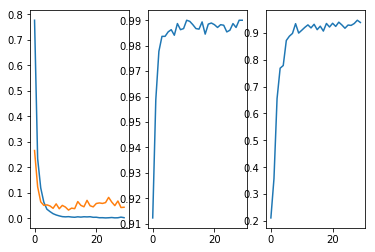

Fold 2:
Epoch: 0
Validation loss: 2.6771634817123413
Validation Accuracy: 0.03264331210191083
F1-Score: 0.01424922963183528

Epoch: 10
Train loss: 0.007545545980489502
Validation loss: 0.07275177887640893
Validation Accuracy: 0.9846735668789809
F1-Score: 0.8441357078882331

Epoch: 20
Train loss: 0.003678762726485729
Validation loss: 0.07601540838368237
Validation Accuracy: 0.9856687898089171
F1-Score: 0.8453884071946839

Epoch: 30
Train loss: 0.002252112655939224
Validation loss: 0.0826648895163089
Validation Accuracy: 0.9850716560509554
F1-Score: 0.8443953399906239

The best result: 
Validation Accuracy: 0.9868630573248408, F1-Score: 0.9016111112915446


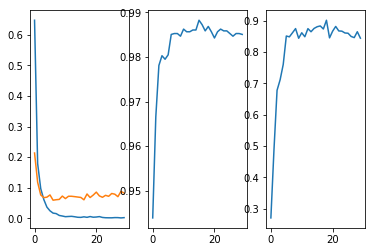

Fold 3:
Epoch: 0
Validation loss: 2.766507089138031
Validation Accuracy: 0.011944677284157585
F1-Score: 0.012640364976546968

Epoch: 10
Train loss: 0.006970333820208907
Validation loss: 0.09020825778134167
Validation Accuracy: 0.982606873428332
F1-Score: 0.876812117007122

Epoch: 20
Train loss: 0.002294696183525957
Validation loss: 0.1253613643348217
Validation Accuracy: 0.9784157585917854
F1-Score: 0.8644182511756837

Epoch: 30
Train loss: 0.0019871226822336515
Validation loss: 0.12004202790558338
Validation Accuracy: 0.9823973176865046
F1-Score: 0.8779500447327234

The best result: 
Validation Accuracy: 0.9819782062028499, F1-Score: 0.9011205996721829


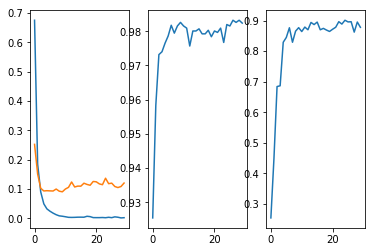

Fold 4:
Epoch: 0
Validation loss: 2.5187520682811737
Validation Accuracy: 0.11473380107304994
F1-Score: 0.029293379564257253

Epoch: 10
Train loss: 0.005395127138278137
Validation loss: 0.10415427363477647
Validation Accuracy: 0.9773008666941808
F1-Score: 0.7858376903183422

Epoch: 20
Train loss: 0.001401442463005272
Validation loss: 0.09344269684515893
Validation Accuracy: 0.9812216260833677
F1-Score: 0.8050550896472093

Epoch: 30
Train loss: 0.003064089092852858
Validation loss: 0.11656134796794504
Validation Accuracy: 0.9787453569954602
F1-Score: 0.8138045856702856

The best result: 
Validation Accuracy: 0.979983491539414, F1-Score: 0.8210692663098027


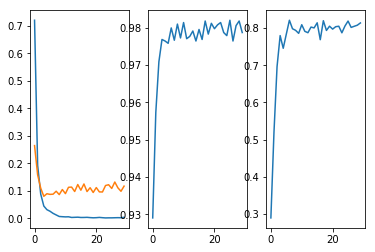

Fold 5:
Epoch: 0
Validation loss: 2.735751658678055
Validation Accuracy: 0.017015706806282723
F1-Score: 0.009211857252865177

Epoch: 10
Train loss: 0.012074042045666526
Validation loss: 0.12294583907350898
Validation Accuracy: 0.9788394415357766
F1-Score: 0.7997040898048499

Epoch: 20
Train loss: 0.0015675289905630052
Validation loss: 0.13969989586621523
Validation Accuracy: 0.9738219895287958
F1-Score: 0.8081087205015918

Epoch: 30
Train loss: 0.0016652678285026922
Validation loss: 0.16142923664301634
Validation Accuracy: 0.9757853403141361
F1-Score: 0.8171819230574969

The best result: 
Validation Accuracy: 0.975130890052356, F1-Score: 0.849908165123425


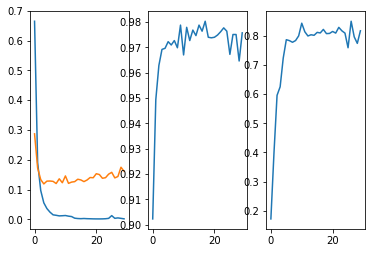

accuracy of folds: [0.9899694723070214, 0.9868630573248408, 0.9819782062028499, 0.979983491539414, 0.975130890052356]
average accuracy: 0.9827850234852964
f1 of folds: [0.9466857224399986, 0.9016111112915446, 0.9011205996721829, 0.8210692663098027, 0.849908165123425]
average f1: 0.8840789729673908


<Figure size 432x288 with 0 Axes>

In [14]:
print('Cross Validation')
config['epochs']=30
acc_list = []
f1_list = []
f = 1
eval_accuracy_fold = [] 
f1_fold = []
model = None
# enumerate splits
for train_index, test_index in kfold.split(data_fold[0]):
    dataloader, count = myDataLoader(data_fold, train_index, test_index)

    print('Fold {}:'.format(f))
    del model
    model = BuildModel(config)
    _, eval_accuracy, f1 = train(config, model, dataloader, if_plot=True, fold_id=f)
    eval_accuracy_fold.append(eval_accuracy)
    f1_fold.append(f1)
    f+=1
print('accuracy of folds: {}'.format(eval_accuracy_fold))
print('average accuracy: {}'.format(sum(eval_accuracy_fold)/fold_num))
print('f1 of folds: {}'.format(f1_fold))
print('average f1: {}'.format(sum(f1_fold)/fold_num))

In [11]:
# predictions, true_labels, eval_loss, eval_accuracy, f1 = test(model, data_fold.to(device), validation = False)

In [12]:
# pk.dump((model,tr_loss_list,eval_loss_list,eval_acc_list,f1_list), open('results/basic_add.pkl','wb'))

In [10]:
# data1 = pd.read_csv("data/train_tyus_v3(NO_FIXEDV).csv", sep=' ', encoding="latin1").fillna(method="ffill")
# data2 = pd.read_csv("data/tyus_train_predicted_9000.csv", sep=' ', encoding="latin1").fillna(method="ffill")
# data1_small = data1[['sent_ind','cve_sent_ind','token','label']].copy()
# data2_small = data2[['sent_ind','cve_sent_ind','token','label']].copy()
# data = pd.concat([data1_small, data2_small], ignore_index=True)
# data.to_csv('data/dataset.csv', index=False)
data = pd.read_csv("data/dataset.csv", encoding="latin1").fillna(method="ffill")
count_label = data.groupby('label')['sent_ind'].count()
# sentence id
i=0
cve_sent_ind = 0
sent_ind = data.loc[0]['sent_ind']
while i<len(data):
    d = data.loc[i]
    if d['sent_ind']==sent_ind:
        data.loc[i, 'cve_sent_ind']=cve_sent_ind
        if d['token']=='.':
            cve_sent_ind=cve_sent_ind+1
        i+=1
    else:
        sent_ind = d['sent_ind']
        cve_sent_ind = 0



In [98]:
count_label

label
<            364
<=            56
=            126
>             27
O          15986
all           32
pn           878
sp           318
update       105
version      147
vr            69
vre          375
vrs           94
Name: sent_ind, dtype: int64

In [28]:
with open('results/cpe.pkl','rb') as f:
    cve_cpe_pnames,cve_cpe_vendors = pk.load(f)
words = add_pname(data, cve_cpe_pnames)
sentences = [" ".join([s[0] for s in sent]) for sent in words]
labels = [[s[1] for s in sent] for sent in words]
substitue = config['substitue']
tags_vals = list(set(data["label"].values)) + [substitue]
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [12]:
grouped = data.groupby(['sent_ind','cve_sent_ind'])
# grouped = [g for g in grouped]
words_wo_tag = [[w[0] for w in s] for s in words]
words_group = list(zip(grouped.groups.keys(),words_wo_tag))

NameError: name 'data' is not defined

In [31]:
len(sentences)

584

In [32]:
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
tokenizer = BertTokenizer.from_pretrained(config['name'], do_lower_case=config['do_lower_case'])
mytexts = []
mylabels = []
for sent, tags in zip(sentences,labels):
    BERT_texts = []
    BERT_labels = np.array([])
    for word, tag in zip(sent.split(),tags):
        sub_words = tokenizer.tokenize(word)
        n_underscore = sub_words.count('_') 
        for i in range(n_underscore):
            sub_words.remove('_')
        tags = np.array([tag for x in sub_words])
        tags[1:] = config['substitue']
        BERT_texts += sub_words
        BERT_labels = np.append(BERT_labels,tags)
    mytexts.append(BERT_texts)
    mylabels.append(BERT_labels)


In [33]:
len(mytexts)

584

In [34]:
mylabels[0]

array(['O', 'O', 'O', 'pn', 'X', 'O', 'O', 'O', 'O', 'O', 'pn', 'X', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
      dtype='<U32')

In [35]:
data.loc[360]

sent_ind        CVE-2002-1912
cve_sent_ind                0
token                    does
label                       O
Name: 360, dtype: object

In [36]:
# i = 0
# for i in range(len(mytexts)):
#     if len(mytexts[i])>200:
#         print(i,len(mytexts[i]))
#         print(mylabels[i][200:])

In [37]:
MAX_LEN = config['MAX_LEN']
#padding data
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in mytexts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in mylabels],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
attention_masks = np.array([[float(i>0) for i in ii] for ii in input_ids])
data_fold = (input_ids, tags, attention_masks)

In [38]:
    import torch
    import torch.nn as nn
    import pickle as pk
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.model_selection import train_test_split
    bs = config['bs']
    input_ids, tags, attention_masks = data_fold
    
    tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                                random_state=1, test_size=0.2)
    tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=1, test_size=0.2)
    
#     val_masks, tst_masks, _, _ = train_test_split(val_masks, val_inputs,
#                                              random_state=1, test_size=0.5)
#     val_inputs, tst_inputs, val_tags, tst_tags = train_test_split(val_inputs, val_tags, 
#                                                                 random_state=1, test_size=0.5)
    
    count = np.unique(tr_tags, return_counts=True)[1]
    
    tr_inputs = torch.tensor(tr_inputs)
    val_inputs = torch.tensor(val_inputs)
    tr_tags = torch.tensor(tr_tags)
    val_tags = torch.tensor(val_tags)
    tr_masks = torch.tensor(tr_masks)
    val_masks = torch.tensor(val_masks)
#     tst_inputs = torch.tensor(tst_inputs)
#     tst_tags = torch.tensor(tst_tags)
#     tst_masks = torch.tensor(tst_masks)
    
    train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs, drop_last=False)

    valid_data = TensorDataset(val_inputs, val_masks, val_tags)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs, drop_last=False)
    
#     test_data = TensorDataset(tst_inputs, tst_masks, tst_tags)
#     test_sampler = SequentialSampler(test_data)
#     test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs, drop_last=False)
    
    dataloader = (train_dataloader, valid_dataloader)
    

In [40]:
import torch
config['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print('The device is ' + torch.cuda.get_device_name(0)) 


The device is GeForce RTX 2080 Ti


In [19]:
count

array([   348,     32,     56,     69,     27,    283,   3429,    100,
          338,    126,     81, 103311,    146,   8454])

In [ ]:
count

In [20]:
np.log((1+1*(np.exp(1)-1))*max(count)/count)

array([6.69329666, 9.07976323, 8.52014744, 8.31139263, 9.24966227,
       6.90005224, 4.40547518, 7.94032895, 6.72245324, 7.70921723,
       8.15104998, 1.        , 7.56189251, 3.50310415])

In [13]:
tags_vals

['vre',
 'all',
 '<=',
 'vr',
 '>',
 'sp',
 'pn',
 'update',
 '<',
 '=',
 'vrs',
 'O',
 'version',
 'X']

mu= 0


/home/junliang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 0
Validation loss: 2.709069103002548
Validation Accuracy: 0.14129960750109027
F1-Score: 0.025518042197616803



/home/junliang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 10
Train loss: 0.01506488275869439
Validation loss: 0.1326754403344239
Validation Accuracy: 0.21107719145224596
F1-Score: 0.5011553428640597

Epoch: 20
Train loss: 0.0017449061948961269
Validation loss: 0.10758961215105955
Validation Accuracy: 0.21282163105102486
F1-Score: 0.5557153802146992

Epoch: 30
Train loss: 0.0008740876946831122
Validation loss: 0.12544967102257942
Validation Accuracy: 0.21238552115133014
F1-Score: 0.5423826743629434

The best result: 
Validation Accuracy: 0.2126035761011775, F1-Score: 0.5592052341090301


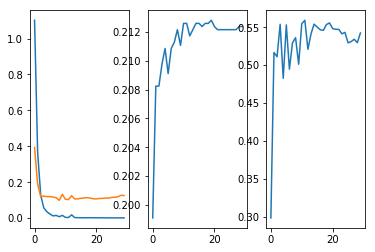

mu= 1
Epoch: 0
Validation loss: 2.5906204283237457
Validation Accuracy: 0.11796772786742259
F1-Score: 0.02629175778629592

Epoch: 10
Train loss: 0.014201781991869212
Validation loss: 0.14665159102878533
Validation Accuracy: 0.9860444832097689
F1-Score: 0.9062622231551594

Epoch: 20
Train loss: 0.004877192579442635
Validation loss: 0.08289464080735343
Validation Accuracy: 0.9875708678587004
F1-Score: 0.9360795779271073

Epoch: 30
Train loss: 0.0025274500503049543
Validation loss: 0.0996068499807734
Validation Accuracy: 0.986698648059311
F1-Score: 0.9204686856354383

The best result: 
Validation Accuracy: 0.9901875272568688, F1-Score: 0.9478587993802596


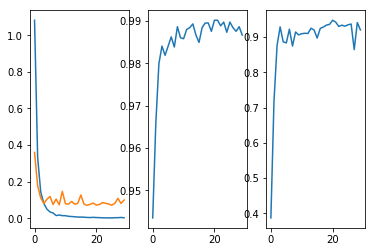

mu= 2
Epoch: 0
Validation loss: 2.6192887127399445
Validation Accuracy: 0.06759703445268207
F1-Score: 0.019868930891088217

Epoch: 10
Train loss: 0.012615673364295314
Validation loss: 0.0782732052175561
Validation Accuracy: 0.9860444832097689
F1-Score: 0.9082580890480789

Epoch: 20
Train loss: 0.0030772273836191743
Validation loss: 0.07805405512772268
Validation Accuracy: 0.9871347579590056
F1-Score: 0.9207752482584838

Epoch: 30
Train loss: 0.0036274427324921514
Validation loss: 0.06743765464125318
Validation Accuracy: 0.989751417357174
F1-Score: 0.9351877279866936

The best result: 
Validation Accuracy: 0.9893153074574793, F1-Score: 0.9394706864194061


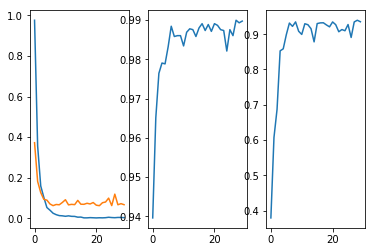

mu= 3
Epoch: 0
Validation loss: 2.6187685132026672
Validation Accuracy: 0.08722197993894461
F1-Score: 0.027748154815443855

Epoch: 10
Train loss: 0.011122254809985558
Validation loss: 0.05933431897574337
Validation Accuracy: 0.9886611426079372
F1-Score: 0.9129649427116829

Epoch: 20
Train loss: 0.004472238444335138
Validation loss: 0.0835722455594805
Validation Accuracy: 0.9860444832097689
F1-Score: 0.9169566655669003

Epoch: 30
Train loss: 0.004895915758485595
Validation loss: 0.08239551709630177
Validation Accuracy: 0.987352812908853
F1-Score: 0.9138756087191623

The best result: 
Validation Accuracy: 0.9890972525076319, F1-Score: 0.9314088203649965


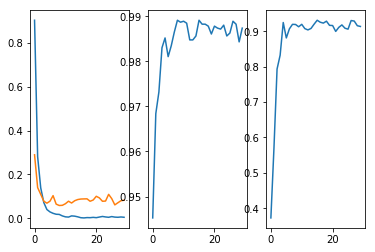

mu= 4
Epoch: 0
Validation loss: 2.7525203227996826
Validation Accuracy: 0.026384648931530745
F1-Score: 0.006931166963392898

Epoch: 10
Train loss: 0.010028537719820936
Validation loss: 0.09038946570217377
Validation Accuracy: 0.9840819886611426
F1-Score: 0.8813573968867411

Epoch: 20
Train loss: 0.0050594869535416365
Validation loss: 0.06967441538654384
Validation Accuracy: 0.9860444832097689
F1-Score: 0.9168454065807787

Epoch: 30
Train loss: 0.004725073301233351
Validation loss: 0.08820607217967336
Validation Accuracy: 0.9851722634103794
F1-Score: 0.9128232992343699

The best result: 
Validation Accuracy: 0.9888791975577845, F1-Score: 0.9311795308552655


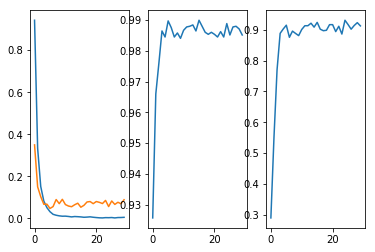

mu= 5
Epoch: 0
Validation loss: 2.729432761669159
Validation Accuracy: 0.031836022677714786
F1-Score: 0.012237225110678986

Epoch: 10
Train loss: 0.00832533425030609
Validation loss: 0.0663900136059965
Validation Accuracy: 0.9851722634103794
F1-Score: 0.9061390158618159

Epoch: 20
Train loss: 0.002165883383713663
Validation loss: 0.05117879594763508
Validation Accuracy: 0.9908416921064108
F1-Score: 0.9428873510652125

Epoch: 30
Train loss: 0.003425807037274353
Validation loss: 0.06972996949843946
Validation Accuracy: 0.987352812908853
F1-Score: 0.93032672803469

The best result: 
Validation Accuracy: 0.9925861317051897, F1-Score: 0.9575836572149728


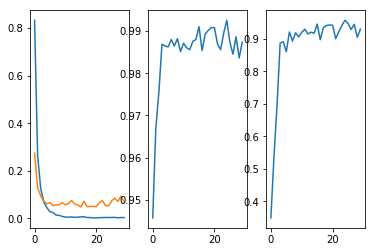

mu= 6
Epoch: 0
Validation loss: 2.7629603147506714
Validation Accuracy: 0.010248582642825993
F1-Score: 0.0053674938807821565

Epoch: 10
Train loss: 0.010393241152632982
Validation loss: 0.08374628920137184
Validation Accuracy: 0.9838639337112952
F1-Score: 0.8799346233820049

Epoch: 20
Train loss: 0.013890826523614426
Validation loss: 0.06471116243119468
Validation Accuracy: 0.9851722634103794
F1-Score: 0.9162843336540134

Epoch: 30
Train loss: 0.0040725216938881205
Validation loss: 0.05720260779526143
Validation Accuracy: 0.9875708678587004
F1-Score: 0.9193437909944614

The best result: 
Validation Accuracy: 0.989751417357174, F1-Score: 0.9387609042917393


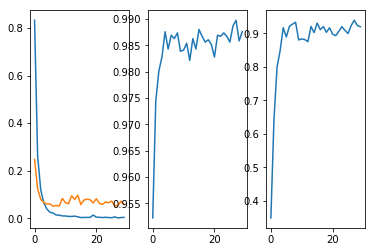

mu= 7
Epoch: 0
Validation loss: 2.5834606885910034
Validation Accuracy: 0.13759267335368514
F1-Score: 0.025840900560830625

Epoch: 10
Train loss: 0.01066038371839871
Validation loss: 0.05834158747893525
Validation Accuracy: 0.9856083733100741
F1-Score: 0.8801445974141708

Epoch: 20
Train loss: 0.0025254011639238645
Validation loss: 0.06515432551532285
Validation Accuracy: 0.9862625381596162
F1-Score: 0.8988732238836907

Epoch: 30
Train loss: 0.0011271253499823312
Validation loss: 0.08739063250504842
Validation Accuracy: 0.9838639337112952
F1-Score: 0.8898139391672687

The best result: 
Validation Accuracy: 0.9884430876580899, F1-Score: 0.9223336783743346


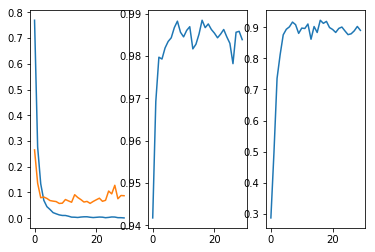

mu= 8
Epoch: 0
Validation loss: 2.71832138299942
Validation Accuracy: 0.07915394679459224
F1-Score: 0.016141525108887805

Epoch: 10
Train loss: 0.012030812562443316
Validation loss: 0.06527223882585531
Validation Accuracy: 0.9847361535106847
F1-Score: 0.8574863564407891

Epoch: 20
Train loss: 0.0026246892191314447
Validation loss: 0.04807308709132485
Validation Accuracy: 0.9901875272568688
F1-Score: 0.9238201743470577

Epoch: 30
Train loss: 0.007440157690628742
Validation loss: 0.08058997993066441
Validation Accuracy: 0.9825556040122111
F1-Score: 0.8680453215629889

The best result: 
Validation Accuracy: 0.9901875272568688, F1-Score: 0.9238201743470577


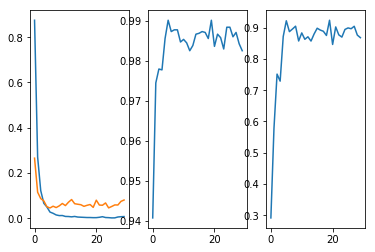

mu= 9
Epoch: 0
Validation loss: 2.577810764312744
Validation Accuracy: 0.12930658525948538
F1-Score: 0.02995098782289104

Epoch: 10
Train loss: 0.010456191709575553
Validation loss: 0.055702450292301364
Validation Accuracy: 0.984954208460532
F1-Score: 0.8891158213343835

Epoch: 20
Train loss: 0.002445034074480645
Validation loss: 0.04874343951996707
Validation Accuracy: 0.9884430876580899
F1-Score: 0.915648307556566

Epoch: 30
Train loss: 0.003195076835496972
Validation loss: 0.05567698254890274
Validation Accuracy: 0.9886611426079372
F1-Score: 0.924632130238861

The best result: 
Validation Accuracy: 0.9899694723070214, F1-Score: 0.9367339679693731


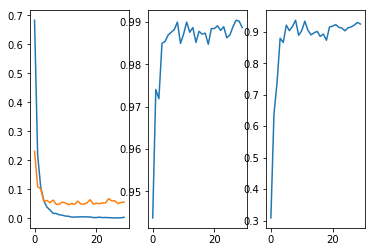

mu= 10
Epoch: 0
Validation loss: 2.6824625730514526
Validation Accuracy: 0.03859572612298299
F1-Score: 0.024273062702316963

Epoch: 10
Train loss: 0.013907077217785021
Validation loss: 0.05769767781748669
Validation Accuracy: 0.984954208460532
F1-Score: 0.8859036595565144

Epoch: 20
Train loss: 0.004865839881434416
Validation loss: 0.048640696393704275
Validation Accuracy: 0.9899694723070214
F1-Score: 0.9355353597342508

Epoch: 30
Train loss: 0.005004256488367294
Validation loss: 0.04990387661200657
Validation Accuracy: 0.9901875272568688
F1-Score: 0.9165758291285833

The best result: 
Validation Accuracy: 0.9910597470562582, F1-Score: 0.9400125827271515


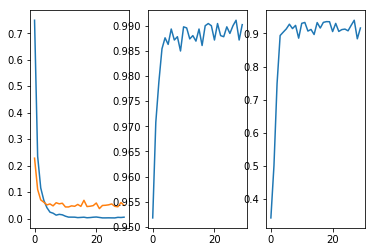

[(0, 0.2126035761011775, 0.5592052341090301),
 (1, 0.9901875272568688, 0.9478587993802596),
 (2, 0.9893153074574793, 0.9394706864194061),
 (3, 0.9890972525076319, 0.9314088203649965),
 (4, 0.9888791975577845, 0.9311795308552655),
 (5, 0.9925861317051897, 0.9575836572149728),
 (6, 0.989751417357174, 0.9387609042917393),
 (7, 0.9884430876580899, 0.9223336783743346),
 (8, 0.9901875272568688, 0.9238201743470577),
 (9, 0.9899694723070214, 0.9367339679693731),
 (10, 0.9910597470562582, 0.9400125827271515)]

<Figure size 432x288 with 0 Axes>

In [43]:
##r=0,5
import warnings
warnings.filterwarnings('once')

model = None
config['epochs']=30

maxf1list = []
maxacclist = []
mu_list = []
for r in range():
    del model
    mu = r
    mu_list.append(mu)
    print('mu=',mu)
#     weight = np.maximum(np.log((1+mu*(np.exp(1)-1))*max(count)/count),1)
    weight =  np.log(max(count)/count)+mu
    weight = torch.tensor(weight)
    #     weight = None
    model = BuildModel(config, weight)
    model, max_acc, max_f1 = train(config, model, dataloader, if_plot=True)
    maxacclist.append(max_acc)
    maxf1list.append(max_f1)
list(zip(mu_list,maxacclist,maxf1list))

mu= 11


/home/junliang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 0
Validation loss: 2.6792466938495636
Validation Accuracy: 0.045791539467945924
F1-Score: 0.015897544099594912



/home/junliang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 10
Train loss: 0.005459608723564695
Validation loss: 0.046080594991508406
Validation Accuracy: 0.990405582206716
F1-Score: 0.9486817669432561

Epoch: 20
Train loss: 0.002741294817921395
Validation loss: 0.0504088718953426
Validation Accuracy: 0.9899694723070214
F1-Score: 0.9365759851950379

Epoch: 30
Train loss: 0.0016973049481748604
Validation loss: 0.04433162111854472
Validation Accuracy: 0.9912778020061055
F1-Score: 0.9325809227059728

The best result: 
Validation Accuracy: 0.990405582206716, F1-Score: 0.9486817669432561


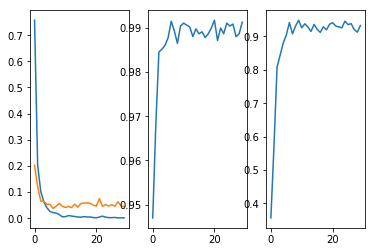

mu= 12
Epoch: 0
Validation loss: 2.6788642406463623
Validation Accuracy: 0.036415176624509375
F1-Score: 0.03534463593025704

Epoch: 10
Train loss: 0.012191555191141864
Validation loss: 0.045427336313878186
Validation Accuracy: 0.9875708678587004
F1-Score: 0.9164258079184632

Epoch: 20
Train loss: 0.003149732774666821
Validation loss: 0.061526018544100225
Validation Accuracy: 0.9880069777583951
F1-Score: 0.9380908195287755

Epoch: 30
Train loss: 0.003754151062457822
Validation loss: 0.05780826071895717
Validation Accuracy: 0.9886611426079372
F1-Score: 0.9261670426460668

The best result: 
Validation Accuracy: 0.9912778020061055, F1-Score: 0.9437575012555818


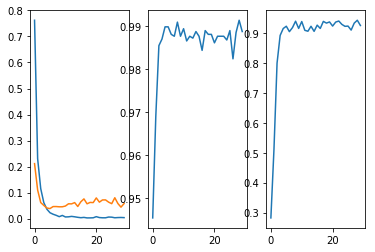

mu= 13
Epoch: 0
Validation loss: 2.7095152735710144
Validation Accuracy: 0.016572176188399478
F1-Score: 0.011112544922788885

Epoch: 10
Train loss: 0.011114477490385374
Validation loss: 0.04059876134124352
Validation Accuracy: 0.989751417357174
F1-Score: 0.9314463354134463

Epoch: 20
Train loss: 0.0020676966407336293
Validation loss: 0.06052771857685002
Validation Accuracy: 0.9886611426079372
F1-Score: 0.9155372258278626

Epoch: 30
Train loss: 0.0032990232789112876
Validation loss: 0.09991948203787615
Validation Accuracy: 0.9838639337112952
F1-Score: 0.8965491851125287

The best result: 
Validation Accuracy: 0.9888791975577845, F1-Score: 0.9388521077525649


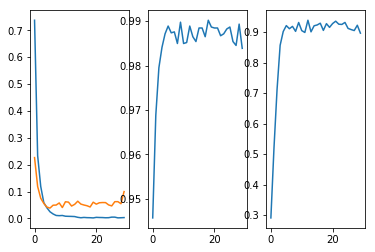

mu= 14
Epoch: 0
Validation loss: 2.6538418531417847
Validation Accuracy: 0.04928041866550371
F1-Score: 0.020094037792625922

Epoch: 10
Train loss: 0.008115852569850783
Validation loss: 0.05166548338456778
Validation Accuracy: 0.9847361535106847
F1-Score: 0.8945677883935779

Epoch: 20
Train loss: 0.005671623195909584
Validation loss: 0.06238616850532708
Validation Accuracy: 0.9847361535106847
F1-Score: 0.8886152257602842

Epoch: 30
Train loss: 0.002482095138596681
Validation loss: 0.064443784969626
Validation Accuracy: 0.9856083733100741
F1-Score: 0.8833159660243685

The best result: 
Validation Accuracy: 0.9840819886611426, F1-Score: 0.9093047568015596


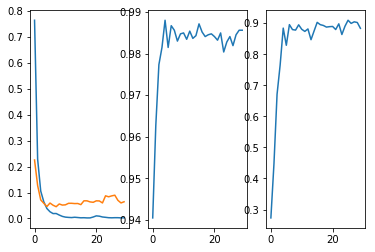

mu= 15
Epoch: 0
Validation loss: 2.8692298233509064
Validation Accuracy: 0.017662450937636284
F1-Score: 0.013526072364506233

Epoch: 10
Train loss: 0.007672619823521624
Validation loss: 0.04208182431466412
Validation Accuracy: 0.9901875272568688
F1-Score: 0.9256655127684054

Epoch: 20
Train loss: 0.005663123319391161
Validation loss: 0.053691447519668145
Validation Accuracy: 0.9888791975577845
F1-Score: 0.9220533605075724

Epoch: 30
Train loss: 0.00204685856103121
Validation loss: 0.05505501288098458
Validation Accuracy: 0.9888791975577845
F1-Score: 0.9169139061559832

The best result: 
Validation Accuracy: 0.9910597470562582, F1-Score: 0.9351066976859569


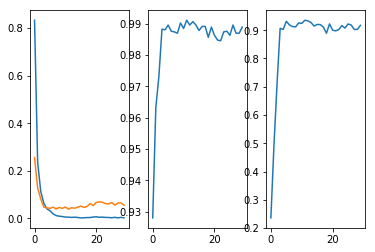

mu= 16
Epoch: 0
Validation loss: 2.5188690423965454
Validation Accuracy: 0.1768425643262102
F1-Score: 0.02756509224782728

Epoch: 10
Train loss: 0.012888320085282127
Validation loss: 0.06529192334710388
Validation Accuracy: 0.984954208460532
F1-Score: 0.9254066622772968

Epoch: 20
Train loss: 0.003049808241970216
Validation loss: 0.043373482851166045
Validation Accuracy: 0.989751417357174
F1-Score: 0.9209757804193217

Epoch: 30
Train loss: 0.0036786939706265303
Validation loss: 0.04792611117227352
Validation Accuracy: 0.9882250327082425
F1-Score: 0.9299869056806264

The best result: 
Validation Accuracy: 0.9899694723070214, F1-Score: 0.9408420128978331


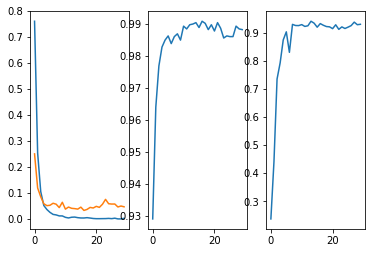

mu= 17
Epoch: 0
Validation loss: 2.6662339568138123
Validation Accuracy: 0.021587440034888793
F1-Score: 0.011417308078484583

Epoch: 10
Train loss: 0.012513355755557617
Validation loss: 0.05005510434421012
Validation Accuracy: 0.9877889228085478
F1-Score: 0.9228650237242905

Epoch: 20
Train loss: 0.0026266773988027126
Validation loss: 0.045391128354822285
Validation Accuracy: 0.9901875272568688
F1-Score: 0.9170350763588548

Epoch: 30
Train loss: 0.0019190282900429642
Validation loss: 0.04735481063471525
Validation Accuracy: 0.9886611426079372
F1-Score: 0.9127266878118442

The best result: 
Validation Accuracy: 0.9910597470562582, F1-Score: 0.9433452673709168


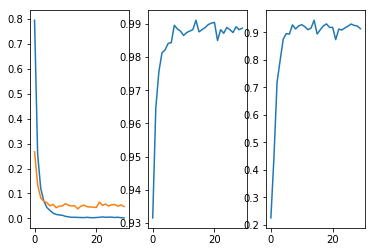

mu= 18
Epoch: 0
Validation loss: 2.7692092061042786
Validation Accuracy: 0.023331879633667684
F1-Score: 0.01901285783565879

Epoch: 10
Train loss: 0.015372982908350727
Validation loss: 0.0585804400179768
Validation Accuracy: 0.9871347579590056
F1-Score: 0.9016143520840099

Epoch: 20
Train loss: 0.003491318264665703
Validation loss: 0.06714971903420519
Validation Accuracy: 0.9858264282599215
F1-Score: 0.8669435748910019

Epoch: 30
Train loss: 0.0033899223102101437
Validation loss: 0.059556448979492416
Validation Accuracy: 0.986698648059311
F1-Score: 0.8767849864303611

The best result: 
Validation Accuracy: 0.9895333624073267, F1-Score: 0.9056049249429828


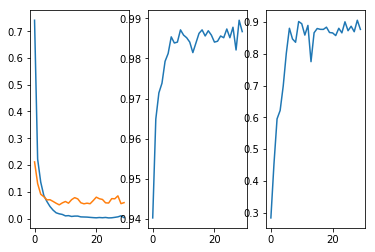

mu= 19
Epoch: 0
Validation loss: 2.6332947313785553
Validation Accuracy: 0.04622764936764064
F1-Score: 0.017093667741764667

Epoch: 10
Train loss: 0.008568217562666784
Validation loss: 0.043993534989567706
Validation Accuracy: 0.9882250327082425
F1-Score: 0.923138317068022

Epoch: 20
Train loss: 0.004638719832291827
Validation loss: 0.04642068038447178
Validation Accuracy: 0.989751417357174
F1-Score: 0.9344862308348006

Epoch: 30
Train loss: 0.004678780820298319
Validation loss: 0.061492158405599184
Validation Accuracy: 0.9862625381596162
F1-Score: 0.9129280888985762

The best result: 
Validation Accuracy: 0.989751417357174, F1-Score: 0.9344862308348006


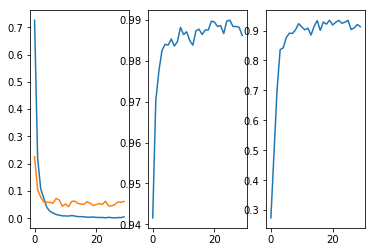

mu= 20
Epoch: 0
Validation loss: 2.7862096428871155
Validation Accuracy: 0.007413868294810292
F1-Score: 0.010762678316166277

Epoch: 10
Train loss: 0.014079845296995094
Validation loss: 0.0712894800453796
Validation Accuracy: 0.9853903183602267
F1-Score: 0.9162323950563352

Epoch: 20
Train loss: 0.002539768989663571
Validation loss: 0.05362050975418242
Validation Accuracy: 0.9875708678587004
F1-Score: 0.9324921243210373

Epoch: 30
Train loss: 0.0026542536332271995
Validation loss: 0.06524170779630367
Validation Accuracy: 0.9864805931094636
F1-Score: 0.9138154977609809

The best result: 
Validation Accuracy: 0.9890972525076319, F1-Score: 0.9428714316148837


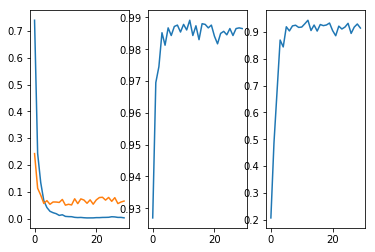

[(11, 0.990405582206716, 0.9486817669432561),
 (12, 0.9912778020061055, 0.9437575012555818),
 (13, 0.9888791975577845, 0.9388521077525649),
 (14, 0.9840819886611426, 0.9093047568015596),
 (15, 0.9910597470562582, 0.9351066976859569),
 (16, 0.9899694723070214, 0.9408420128978331),
 (17, 0.9910597470562582, 0.9433452673709168),
 (18, 0.9895333624073267, 0.9056049249429828),
 (19, 0.989751417357174, 0.9344862308348006),
 (20, 0.9890972525076319, 0.9428714316148837)]

<Figure size 432x288 with 0 Axes>

In [44]:
##r=0,5
import warnings
warnings.filterwarnings('once')

model = None
config['epochs']=30

maxf1list = []
maxacclist = []
mu_list = []
for r in range(11,21):
    del model
    mu = r
    mu_list.append(mu)
    print('mu=',mu)
#     weight = np.maximum(np.log((1+mu*(np.exp(1)-1))*max(count)/count),1)
    weight =  np.log(max(count)/count)+mu
    weight = torch.tensor(weight)
    #     weight = None
    model = BuildModel(config, weight)
    model, max_acc, max_f1 = train(config, model, dataloader, if_plot=True)
    maxacclist.append(max_acc)
    maxf1list.append(max_f1)
list(zip(mu_list,maxacclist,maxf1list))

mu= 5


/home/junliang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 0
Validation loss: 2.591493248939514
Validation Accuracy: 0.04491931966855647
F1-Score: 0.017652964871837103



/home/junliang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 10
Train loss: 0.007536955193306009
Validation loss: 0.051231201068731025
Validation Accuracy: 0.9882250327082425
F1-Score: 0.9083984269760884

Epoch: 20
Train loss: 0.004509907242997239
Validation loss: 0.03958230241551064
Validation Accuracy: 0.9921500218054949
F1-Score: 0.9474950681085859

Epoch: 30
Train loss: 0.003091436485798719
Validation loss: 0.08103318813118676
Validation Accuracy: 0.9864805931094636
F1-Score: 0.8346395440355331

Epoch: 40
Train loss: 0.006183869986368033
Validation loss: 0.06609931393904844
Validation Accuracy: 0.9886611426079372
F1-Score: 0.9198326174310771

Epoch: 50
Train loss: 0.002166515199254112
Validation loss: 0.060408075162740715
Validation Accuracy: 0.9886611426079372
F1-Score: 0.9426685936139232

The best result: 
Validation Accuracy: 0.9910597470562582, F1-Score: 0.9493122141524739


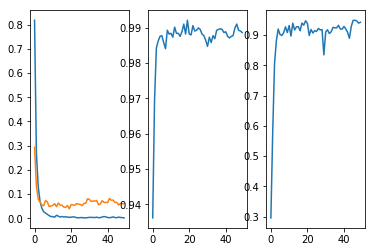

[(5, 0.9910597470562582, 0.9493122141524739)]

<Figure size 432x288 with 0 Axes>

In [45]:
import warnings
warnings.filterwarnings('once')

model = None
config['epochs']=50

maxf1list = []
maxacclist = []
mu_list = []
for r in range(5,6):
    del model
    mu = r
    mu_list.append(mu)
    print('mu=',mu)
#     weight = np.maximum(np.log((1+mu*(np.exp(1)-1))*max(count)/count),1)
    weight =  np.log(max(count)/count)+mu
    weight = torch.tensor(weight)
    #     weight = None
    model = BuildModel(config, weight)
    model, max_acc, max_f1 = train(config, model, dataloader, if_plot=True)
    maxacclist.append(max_acc)
    maxf1list.append(max_f1)
list(zip(mu_list,maxacclist,maxf1list))

In [39]:
with open('results/model_weighted.pkl','wb') as f:
    pk.dump(model, f)

Test loss: 0.07497167098335922
Test Accuracy: 0.9864805931094636
micro F1-Score: 0.9864805931094636
macro F1-Score: 0.9463076161616104
weighted F1-Score: 0.9867058665854783

test counts:
            0
722        pn
22     update
3593        O
4           >
10         <=
50          <
6         all
22          =
39         sp
56        vre
40    version
8          vr
14        vrs
0           X

              precision    recall  f1-score   support

           <       1.00      0.94      0.97        50
          <=       0.71      1.00      0.83        10
           =       0.95      0.95      0.95        22
           >       1.00      1.00      1.00         4
           O       1.00      0.99      0.99      3593
         all       1.00      1.00      1.00         6
          pn       0.95      1.00      0.98       722
          sp       0.86      0.97      0.92        39
      update       0.85      1.00      0.92        22
     version       0.90      0.93      0.91        40
       

/home/junliang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


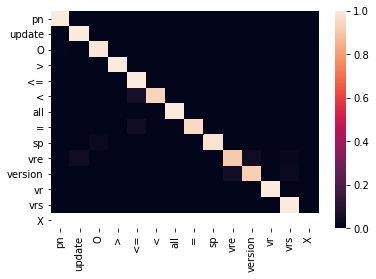

In [55]:
# model = None
# with open('results/model_weighted.pkl','rb') as f:
#     model = pk.load(f)
predictions, true_labels, eval_loss, eval_accuracy, f1 = test(config, model, valid_dataloader, validation = False)

In [188]:
pk.dump(model,open('results/model.pkl','wb'))

In [63]:
    order_ids = np.array([[(i,j) for j in range(MAX_LEN)] for i in range(len(input_ids))])

    tr_order, val_order, _, _ = train_test_split(order_ids, input_ids,
                                             random_state=1, test_size=0.2)
    tr_order = torch.tensor(tr_order)
    val_order = torch.tensor(val_order)
    
    valid_data = TensorDataset(val_inputs, val_masks, val_tags, val_order)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs, drop_last=False)
    
    dataloader = (train_dataloader, valid_dataloader)

In [72]:
from seqeval.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix ,f1_score, accuracy_score, classification_report
def test_(config, model, dataloader, validation = False):
    #dataloader is only validation data or test data
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels, order, logit = [], [], [], []
    for batch in dataloader:
        batch = tuple(t.to(config['device']) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_order = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        
        active = ((b_input_mask.view(-1) == 1) * (b_labels.view(-1) != len(tag2idx)-1))
        active_logits = logits.view(-1, len(tag2idx))[active].cpu().numpy()
        active_labels = b_labels.view(-1)[active].cpu().numpy()
        active_order = b_order.view(-1,2)[active].cpu().numpy()
        pred_labels = np.argmax(active_logits, axis=1)
#         label_ids = b_labels.to('cpu').numpy()
#         logits = logits.detach().cpu().numpy()
        predictions.append(pred_labels)
        true_labels.append(active_labels)
        order.append(active_order)
        logit.append(active_logits)
        
#         tmp_eval_accuracy = np.sum(pred_labels == active_labels) / len(active_labels)
        
        eval_loss += tmp_eval_loss.mean().item()
#         eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
#     eval_accuracy = eval_accuracy/nb_eval_steps
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    order = np.concatenate(order)
    logit = np.concatenate(logit)
    
    
    eval_accuracy = accuracy_score(true_labels, predictions, normalize=True, sample_weight=None)
    f1 = f1_score(true_labels, predictions, average='macro')
    if validation==True:
        return eval_loss, eval_accuracy, f1
    else:
        print("Test loss: {}".format(eval_loss))
        print("Test Accuracy: {}".format(eval_accuracy))
        print("micro F1-Score: {}".format(f1_score(true_labels, predictions, average='micro',)))
        print("macro F1-Score: {}".format(f1))
        print("weighted F1-Score: {}".format(f1_score(true_labels, predictions, average='weighted')))
        
        pred_tags = [tags_vals[p] for p in predictions]
        valid_tags = [tags_vals[l] for l in true_labels]
        counts = [valid_tags.count(tag) for tag in tags_vals]
        cfs_mat = confusion_matrix(valid_tags, pred_tags,tags_vals)
        cfs_with_index = pd.DataFrame(cfs_mat, index = tags_vals,
                      columns = tags_vals)
        cfs_mat_norm = cfs_mat/cfs_mat.sum(axis=1, keepdims = True)
        cfs_with_index_norm = pd.DataFrame(cfs_mat_norm, index = tags_vals,
                      columns = tags_vals)
        print('')
        print('test counts:')
        print(pd.DataFrame(tags_vals,counts))
        print('')
        print(classification_report(valid_tags, pred_tags))
        print('')
        print('Confusion matrix:')
        print(cfs_with_index)
        sn.heatmap(cfs_with_index_norm)
        print('')
        return predictions, true_labels, logit, order, eval_loss, eval_accuracy, f1

Test loss: 0.07497167098335922
Test Accuracy: 0.9864805931094636
micro F1-Score: 0.9864805931094636
macro F1-Score: 0.9463076161616104
weighted F1-Score: 0.9867058665854783

test counts:
            0
722        pn
22     update
3593        O
4           >
10         <=
50          <
6         all
22          =
39         sp
56        vre
40    version
8          vr
14        vrs
0           X

              precision    recall  f1-score   support

           <       1.00      0.94      0.97        50
          <=       0.71      1.00      0.83        10
           =       0.95      0.95      0.95        22
           >       1.00      1.00      1.00         4
           O       1.00      0.99      0.99      3593
         all       1.00      1.00      1.00         6
          pn       0.95      1.00      0.98       722
          sp       0.86      0.97      0.92        39
      update       0.85      1.00      0.92        22
     version       0.90      0.93      0.91        40
       

/home/junliang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


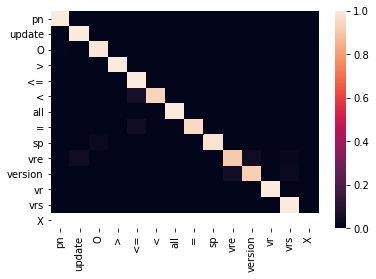

In [73]:
predictions, true_labels, logit, order, eval_loss, eval_accuracy, f1 = test_(config, model, valid_dataloader, validation = False)

In [74]:
false_id = (predictions!=true_labels).nonzero()

false_p = predictions[false_id]

false_t = true_labels[false_id]

false_o = order[false_id]

false_set = [((false_t[i], tags_vals[false_t[i]]),'->',(false_p[i], tags_vals[false_p[i]]), tuple(false_o[i])) for i in range(len(false_t))]

false_set.sort()

print(len(false_set))
false_set

62


[((0, 'pn'), '->', (2, 'O'), (147, 39)),
 ((2, 'O'), '->', (0, 'pn'), (41, 7)),
 ((2, 'O'), '->', (0, 'pn'), (41, 15)),
 ((2, 'O'), '->', (0, 'pn'), (49, 20)),
 ((2, 'O'), '->', (0, 'pn'), (49, 21)),
 ((2, 'O'), '->', (0, 'pn'), (49, 22)),
 ((2, 'O'), '->', (0, 'pn'), (62, 13)),
 ((2, 'O'), '->', (0, 'pn'), (62, 18)),
 ((2, 'O'), '->', (0, 'pn'), (66, 15)),
 ((2, 'O'), '->', (0, 'pn'), (66, 38)),
 ((2, 'O'), '->', (0, 'pn'), (67, 22)),
 ((2, 'O'), '->', (0, 'pn'), (159, 21)),
 ((2, 'O'), '->', (0, 'pn'), (159, 22)),
 ((2, 'O'), '->', (0, 'pn'), (159, 23)),
 ((2, 'O'), '->', (0, 'pn'), (201, 6)),
 ((2, 'O'), '->', (0, 'pn'), (223, 56)),
 ((2, 'O'), '->', (0, 'pn'), (223, 57)),
 ((2, 'O'), '->', (0, 'pn'), (223, 70)),
 ((2, 'O'), '->', (0, 'pn'), (223, 81)),
 ((2, 'O'), '->', (0, 'pn'), (223, 95)),
 ((2, 'O'), '->', (0, 'pn'), (225, 52)),
 ((2, 'O'), '->', (0, 'pn'), (237, 6)),
 ((2, 'O'), '->', (0, 'pn'), (295, 22)),
 ((2, 'O'), '->', (0, 'pn'), (295, 23)),
 ((2, 'O'), '->', (0, 'pn'), 

In [ ]:
false_logit = logit[false_id]

In [165]:
n,m = 47, 19

In [388]:
words_group[121]

(('CVE-2009-0891', 0),
 ['Product',
  'name',
  'is',
  'websphere',
  'application',
  'server',
  '.',
  'The',
  'Web',
  'Services',
  'Security',
  'component',
  'in',
  'IBM',
  'WebSphere',
  'Application',
  'Server',
  '7',
  'before',
  'Fix',
  'Pack',
  '1',
  '(',
  '7.0.0.1',
  ')',
  ',',
  '6.1',
  'before',
  'Fix',
  'Pack',
  '23',
  '(',
  '6.1.0.23),and',
  '6.0.2',
  'before',
  'Fix',
  'Pack',
  '33',
  '(',
  '6.0.2.33',
  ')',
  'does',
  'not',
  'properly',
  'enforce',
  '(',
  '1',
  ')',
  'nonce',
  'and',
  '(',
  '2',
  ')',
  'timestamp',
  'expiration',
  'values',
  'in',
  'WS',
  '-',
  'Security',
  'bindings',
  'as',
  'stored',
  'in',
  'the',
  'com.ibm.wsspi.wssecurity.core',
  'custom',
  'property',
  ',',
  'which',
  'allows',
  'remote',
  'authenticated',
  'users',
  'to',
  'conduct',
  'session',
  'hijacking',
  'attacks',
  '.'])

In [167]:
sentences[n]

'Product name is ultimate auction . NOTE : the affected version might be wrong since the current version as of 20060116 is 3.6.1 .'

In [168]:
list(zip(range(len(mytexts)),mytexts[n],mylabels[n]))

[(0, 'product', 'O'),
 (1, 'name', 'O'),
 (2, 'is', 'O'),
 (3, 'ultimate', 'pn'),
 (4, 'auction', 'pn'),
 (5, '.', 'O'),
 (6, 'note', 'O'),
 (7, ':', 'O'),
 (8, 'the', 'O'),
 (9, 'affected', 'O'),
 (10, 'version', 'O'),
 (11, 'might', 'O'),
 (12, 'be', 'O'),
 (13, 'wrong', 'O'),
 (14, 'since', 'O'),
 (15, 'the', 'O'),
 (16, 'current', 'O'),
 (17, 'version', 'O'),
 (18, 'as', 'O'),
 (19, 'of', 'O'),
 (20, '2006', 'O'),
 (21, '##01', 'X'),
 (22, '##16', 'X'),
 (23, 'is', 'O'),
 (24, '3', 'O'),
 (25, '.', 'X'),
 (26, '6', 'X'),
 (27, '.', 'X'),
 (28, '1', 'X'),
 (29, '.', 'O')]

In [300]:
list(zip(mytexts[n],mylabels[n]))[m]

('##u', 'X')

In [319]:
data[data.sent_ind==words_group[n][0][0]]

,sent_ind,cve_sent_ind,token,label
9081,CVE-2001-0435,0,The,O
9082,CVE-2001-0435,0,split,O
9083,CVE-2001-0435,0,key,O
9084,CVE-2001-0435,0,mechanism,O
9085,CVE-2001-0435,0,used,O
9086,CVE-2001-0435,0,by,O
9087,CVE-2001-0435,0,PGP,O
9088,CVE-2001-0435,0,7,pn
9089,CVE-2001-0435,0,allows,O
9090,CVE-2001-0435,0,a,O


In [8]:
data = pd.read_csv("data/dataset.csv", encoding="latin1").fillna(method="ffill")
count_label = data.groupby('label')['sent_ind'].count()
# sentence id
i=0
cve_sent_ind = 0
sent_ind = data.loc[0]['sent_ind']
while i<len(data):
    d = data.loc[i]
    if d['sent_ind']==sent_ind:
        data.loc[i, 'cve_sent_ind']=cve_sent_ind
        if d['token']=='.':
            cve_sent_ind=cve_sent_ind+1
        i+=1
    else:
        sent_ind = d['sent_ind']
        cve_sent_ind = 0
        
with open('data/cpe.pkl','rb') as f:
    cve_cpe_pnames,cve_cpe_vendors = pk.load(f)
words = add_pname(data, cve_cpe_pnames)
sentences = [" ".join([s[0] for s in sent]) for sent in words]
labels = [[s[1] for s in sent] for sent in words]
substitue = config['substitue']
tags_vals = list(set(data["label"].values)) + [substitue]
tag2idx = {t: i for i, t in enumerate(tags_vals)}

grouped = data.groupby(['sent_ind','cve_sent_ind'])
# grouped = [g for g in grouped]
words_wo_tag = [[w[0] for w in s] for s in words]
words_group = list(zip(grouped.groups.keys(),words_wo_tag))

In [9]:
list(grouped.groups.keys())[91]

('CVE-2007-2056', 0)

In [10]:
cve_cpe_pnames['CVE-2007-2056']

[]

In [12]:
def remove_anchor(words, words_wo_tag, group_keys):
    words_wo_anchor = []
    words_wo_anchor_tag = []
    for i in range(len(words)):
        if cve_cpe_pnames[group_keys[i][0]]:
            find_dot = words_wo_tag[i].index('.')
            words_wo_anchor.append(words[i][find_dot+1:])
            words_wo_anchor_tag.append(words_wo_tag[i][find_dot+1:])
        else:
            words_wo_anchor.append(words[i])
            words_wo_anchor_tag.append(words_wo_tag[i])
    return words_wo_anchor, words_wo_anchor_tag
words_wo_anchor, words_wo_anchor_tag = remove_anchor(words, words_wo_tag, list(grouped.groups.keys()))

In [13]:
# predictions = [[l[1] for w in l] for l in words_wo_anchor]
predictions = [[w[1] for w in l] for l in words_wo_anchor]

In [14]:
# p = 0
# grouped_tags = []
# for i in range(len(words_wo_tag)):
#     grouped_tags.append(list(predictions[p:p+len(words_wo_tag[i])]))
#     p+=len(words_wo_tag[i])

In [15]:
grouped_tags=predictions

In [16]:
grouped_tags

[['O',
  'O',
  'O',
  'O',
  'pn',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['pn',
  'pn',
  'pn',
  'O',
  'pn',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'pn',
  'pn',
  'pn',
  'vre',
  '=',
  '<',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'pn',
  'version',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['pn',
  'pn',
  'vre',
  '=',
  '<',
  'O',
  'O',
  

In [17]:
def output_pn_vs(tag_register):
    
    if 'all' in tag_register:
        vs = tag_register['all']
    elif 'version' in tag_register:
        update = tag_register['update'].get('version','') if 'update' in tag_register else ''
        vs = tag_register['version'] + ' ' + update
    elif 'vrs' not in tag_register and 'vre' not in tag_register and 'vr' not in tag_register:
        vs = ''
    elif 'vrs' not in tag_register and 'vre' not in tag_register and 'vr' in tag_register:
        update = tag_register['update'].get('vr','') if 'update' in tag_register else ''
        vs = tag_register['vr'] + ' ' + update
    elif '<' not in tag_register and '<=' not in tag_register and '>' not in tag_register:
        vs = ''
    else:
        if 'vr' in tag_register:
            if '<' in tag_register or '<=' in tag_register:
                if 'vre' not in tag_register:
                    vre = tag_register['vr']
                    vrs = tag_register.get('vrs','')
                else:
                    vre = tag_register['vre']
                    vrs = tag_register.get('vrs',tag_register['vr'])
            elif '>' in tag_register:
                if 'vrs' not in tag_register:
                    vrs = tag_register['vr']
                    vre = tag_register.get('vre','')
                else:
                    vrs = tag_register['vrs']
                    vre = tag_register.get('vre',tag_register['vr'])

            tag_register['vrs'] = vrs
            tag_register['vre'] = vre
        else:
            vrs = tag_register.get('vrs','')
            vre = tag_register.get('vre','')        
    
        update = tag_register['update'].get('vrs','') if 'update' in tag_register else ''
        vrs += ' ' + update
        update = tag_register['update'].get('vre','') if 'update' in tag_register else ''
        vre += ' ' + update
        if '<=' in tag_register:
            vs = '[' + vrs + ',' + vre + ']' 
        elif '<' in tag_register:
            if '=' in tag_register:
                vs = '[' + vrs + ' , ' + vre + ']'
            else:
                vs = '[' + vrs + ' , ' + vre + ')'
        elif '>' in tag_register:
            if '=' in tag_register:
                vs = '[' + vrs + ' , ' + vre + ']'
            else:
                vs = '(' + vrs + ' , ' + vre + ')'
    pn = tag_register.get('pn',[])
#     print(tag_register)
    return pn, vs, tag_register
            
def output(tag_register): 
    if vs!='' and 'sp' not in tag_register:
        done = set()
        for pn in pn_list:
            if pn not in done:
                pn_vs_dict[pn]=pn_vs_dict.get(pn,[])+[vs]
            done.add(pn)
        print(i,j,tag_register)
        print(vs)

pn_vs_dict = {}
for i in range(len(words_wo_tag)):
    t = grouped_tags[i]
    w = words_wo_anchor_tag[i]
    tag_register = {'pn':[]} 
    vs_now = None
    for j in range(len(w)+1):
        
        if j==len(w):
            pn_list, vs,_ = output_pn_vs(tag_register)
            output(tag_register)
            break
        
        if t[j]!='O':
            tj = t[j]
            
            if tj == 'pn':
                pn_list, vs, tag_register = output_pn_vs(tag_register)
                if vs=='':
                    if j==0 or t[j-1]!='pn':
                        if 'pn' not in tag_register:
                            tag_register['pn'] = []
                        tag_register['pn'].append(w[j])
                    else:
                        tag_register['pn'][-1] += ' ' + w[j]
                else:
                    output(tag_register)
                    tag_register = {'pn':[w[j]]} 
                    
            elif tj == 'sp':
                pn_list, vs, tag_register = output_pn_vs(tag_register)
                
                output(tag_register)
                
                tag_register['sp']=True
                if 'all' in tag_register:
                    tag_register.pop('all')
            
            
            elif tj=='update':
                vs_now = tag_register.get('vs_now','')
                if '<' in tag_register or '<=' in tag_register: 
                    if 'vre' not in tag_register:
                        tag_register['vre'] = tag_register['vrs']
                        vs_now = 'vre'
                elif '>' in tag_register:
                    if 'vrs' not in tag_register:
                        tag_register['vrs'] = tag_register['vre']
                        vs_now = 'vrs'
                
                if 'update' not in tag_register:
                    tag_register['update'] = {}
                if vs_now not in tag_register['update']:
                    tag_register['update'][vs_now] = w[j]
                    if 'sp' in tag_register:
                        tag_register.pop('sp')
                else:
                    tag_register['update'][vs_now] += ' ' + w[j]
                    
            else:
                if 'sp' in tag_register:
#                     if 'pn' not in tag_register:
#                         tag_register['pn']=pn_list
                    tag_register = {'pn':tag_register['pn']}
                tag_register[tj] = w[j]
                
                if tj in ['version','vr','vrs','vre']:
                    if 'vs_now' in tag_register and tag_register['vs_now']=='':
                        tag_register['update'][tj] = tag_register['update']['']
                        tag_register['update'].pop('')
                    tag_register['vs_now'] = tj
                
            
            

2 30 {'pn': ['InterScan Virus Wall'], 'vre': '3.32', 'vs_now': 'vre', '=': 'and', '<': 'earlier'}
[  , 3.32 ]
3 43 {'pn': ['PGP'], 'version': '7', 'vs_now': 'version'}
7 
4 41 {'pn': ['Cerberus FTP'], 'vre': '1.5', 'vs_now': 'vre', '=': 'and', '<': 'earlier'}
[  , 1.5 ]
5 42 {'pn': ['Instant Messenger', 'AIM'], 'vre': '4.8', 'vs_now': 'vre', 'update': {'vre': 'beta'}, '=': 'and', '<': 'earlier'}
[  , 4.8 beta]
6 52 {'pn': ['xpressa'], 'vrs': '1.2.5', 'vs_now': 'vre', '<=': 'through', 'vre': '1.2.7.4'}
[1.2.5 ,1.2.7.4 ]
7 19 {'pn': ['DI-804'], 'version': '4.68', 'vs_now': 'version'}
4.68 
7 22 {'pn': ['Dl-704'], 'version': 'V2.56b6', 'vs_now': 'version'}
V2.56b6 
7 26 {'pn': ['Dl-704'], 'version': 'V2.56b5', 'vs_now': 'version'}
V2.56b5 
7 43 {'pn': ['BEFW11S4'], 'vrs': '1.37.2', 'vs_now': 'vre', '<=': 'through', 'vre': '1.42.7'}
[1.37.2 ,1.42.7 ]
7 47 {'pn': ['WAP11'], 'version': '1.3', 'vs_now': 'version'}
1.3 
7 74 {'pn': ['WAP11'], 'version': '1.4', 'vs_now': 'version'}
1.4 
8 45 {'

558 72 {'pn': ['Spark'], 'version': '2.3.0', 'vs_now': 'version'}
2.3.0 
560 29 {'pn': ['FreeRDP'], '<': 'to', 'vre': '2.0.0-rc4', 'vs_now': 'vre'}
[  , 2.0.0-rc4 )
561 43 {'pn': ['UEM'], '<': 'than', 'vre': '12.9.1', 'vs_now': 'vre'}
[  , 12.9.1 )
562 31 {'pn': ['Octopus Deploy'], 'vrs': '2', 'vs_now': 'vrs', '=': 'and', '>': 'later'}
[2  ,  ]
565 14 {'pn': ['ATP'], 'vrs': '5', 'vs_now': 'vre', '<': 'to', 'vre': '5.0.3'}
[5  , 5.0.3 )
567 11 {'pn': ['ATP'], 'vrs': '5', 'vs_now': 'vre', '<': 'to', 'vre': '5.0.3'}
[5  , 5.0.3 )
572 7 {'pn': [], '<': 'to', 'vre': '11.7.0.236', 'vs_now': 'vre'}
[  , 11.7.0.236 )
574 9 {'pn': [], '<': 'to', 'vre': '5.2.24', 'vs_now': 'vre'}
[  , 5.2.24 )
574 14 {'pn': [], '<': 'to', 'vre': '6.0.2', 'vs_now': 'vre'}
[  , 6.0.2 )
580 34 {'pn': ['MVision Endpoint', 'MVision Endpoint'], '<': 'to', 'vre': '18.11.31.62', 'vs_now': 'vre', 'update': {'vre': 'Update 1'}}
[  , 18.11.31.62 Update 1)
581 30 {'pn': ['Chrome'], '<': 'to', 'vre': '72.0.3626.81', 'vs_now'

In [419]:
# words_wo_anchor[7]

In [18]:
pn_vs_dict

{'InterScan Virus Wall': ['[  , 3.32 ]'],
 'PGP': ['7 '],
 'Cerberus FTP': ['[  , 1.5 ]'],
 'Instant Messenger': ['[  , 4.8 beta]'],
 'AIM': ['[  , 4.8 beta]'],
 'xpressa': ['[1.2.5 ,1.2.7.4 ]'],
 'DI-804': ['4.68 '],
 'Dl-704': ['V2.56b6 ', 'V2.56b5 '],
 'BEFW11S4': ['[1.37.2 ,1.42.7 ]'],
 'WAP11': ['1.3 ', '1.4 '],
 'EMR5000': ['[1.16 ,1.18 ]'],
 'Personal Firewall': ['[  , 2.1.4 ]'],
 'KPF': ['[  , 2.1.4 ]'],
 'Routefinder 550': ['[  , 4.63 ]'],
 'Nessus': ['[  , 2.0.6 )'],
 'StoryServer': ['4 ', '5 '],
 'Vignette': ['V/5 ', 'V/6 '],
 'Bugzilla': ['[  , 2.16.3 ]',
  '[2.17.1 ,2.17.4 ]',
  '[2.17.1 ,2.20.4 ]',
  '[2.22.x  , 2.22.3 )',
  '[3.x  , 3.0.1 )'],
 'Zinf': ['2.2.1 '],
 'aspWebAlbum': ['3.2 '],
 'pGina': ['[1.7.6  ,  ]'],
 'Webmail Server': ['5.2.7 '],
 'Extreme Messageboard': ['SP3 ', 'beta '],
 'XMB': ['SP3 ', 'beta '],
 'cPanel': ['9.1.0-R85 '],
 'Application Access Server': ['[  , 1.0.37 ]'],
 'A - A - S': ['[  , 1.0.37 ]'],
 'Internet Explorer': ['[5 ,6 ]',
  '[7 ,10 ]',

In [159]:
len(words_wo_anchor[0])

18

In [99]:
count_label

label
<            364
<=            56
=            126
>             27
O          15986
all           32
pn           878
sp           318
update       105
version      147
vr            69
vre          375
vrs           94
Name: sent_ind, dtype: int64

In [343]:
indd = list(set(data[data.label=='update'].sent_ind))#.iloc[0:30]#.head(10)

In [337]:
cve_cpe_pnames['CVE-2017-4941']

['fusion', 'workstation_pro', 'workstation pro', 'esxi']

In [443]:
# i=-1
# i+=1
# data[data.sent_ind==indd[i]].iloc[0:]

In [509]:
a=list(grouped.groups.keys())[301]
print(a)
data[data['sent_ind']==a[0]]

('CVE-2017-14754', 0)


,sent_ind,cve_sent_ind,token,label
15218,CVE-2017-14754,0,OpenText,O
15219,CVE-2017-14754,0,Document,pn
15220,CVE-2017-14754,0,Sciences,pn
15221,CVE-2017-14754,0,xPression,pn
15222,CVE-2017-14754,0,(,O
15223,CVE-2017-14754,0,formerly,O
15224,CVE-2017-14754,0,EMC,O
15225,CVE-2017-14754,0,Document,pn
15226,CVE-2017-14754,0,Sciences,pn
15227,CVE-2017-14754,0,xPression,pn


In [497]:
data.label.iloc[2761]='sp'

In [494]:
data.iloc[2757].label

'version'

In [498]:
data.to_csv('data/dataset.csv', index=False)

In [256]:

data1 = pd.read_csv("data/dataset1.csv", encoding="latin1").fillna(method="ffill")

In [259]:
data1.iloc[7796]

sent_ind        CVE-2019-3584
cve_sent_ind                0
token                  Update
label                  update
Name: 7796, dtype: object